# Classifying Diseases Using Machine Learning

Developing a machine learning model to evaluate individual health risks

> **Using DUMMY data**

`BUKAN DATA SEBENARNYA`


This notebook made with ❤️ Edo Septian





# 1. Environment Setup
First, let's install and import all necessary packages for our hypertension classification project.

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # Create requirements.txt directly in colab
# %%writefile /content/drive/MyDrive/Colab/hypertension_risk/requirements.txt
# numpy
# pandas
# scipy
# scikit-learn
# lightgbm
# shap
# matplotlib
# seaborn
# joblib

Writing /content/drive/MyDrive/Colab/requirements.txt


In [ ]:
# Install packages from requirements.txt
!pip install -r /content/drive/MyDrive/Colab/hypertension_risk/requirements.txt

In [23]:
# 1. BASIC LIBRARIES
# For data manipulation and analysis
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 2. MACHINE LEARNING LIBRARIES
# For data preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# For model evaluation
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, auc, roc_curve,
    classification_report
)

# Main model - LightGBM
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# 3. ADDITIONAL TOOLS
# For model interpretation
import shap
# For saving/loading models
import joblib
# For system operations
import os
# For logging information
import logging
# For statistical operations
from scipy import stats
# For time operations
from datetime import datetime
# For maintainability and reliability code
from typing import List, Dict, Tuple, Any, Union
# For interactive widget
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets

# 4. SETUP CONFIGURATIONS
# Configure logging to track what's happening
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set visualization styles
plt.style.use('default')
sns.set_theme()
sns.set_context("notebook")  # Makes visualizations readable for notebooks
sns.set_palette("husl")     # Uses a colorful, distinguishable color palette

print("✅ All packages imported successfully!")

✅ All packages imported successfully!


# 2. Data Loading and Exploration
Let's load our training and testing datasets from Google Drive and perform initial exploration.

**Note**: Make sure your data files are uploaded to Google Drive in the correct location.

In [2]:
def load_data(train_path: str, test_path: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load and perform initial check on training and testing datasets.

    Parameters:
    -----------
    train_path : str
        Path to training dataset CSV file
    test_path : str
        Path to testing dataset CSV file

    Returns:
    --------
    Tuple[pd.DataFrame, pd.DataFrame]
        Training and testing datasets

    Raises:
    -------
    FileNotFoundError
        If either file is not found
    """
    try:
        # Load datasets
        train_data = pd.read_csv(train_path)
        test_data = pd.read_csv(test_path)

        # Print dataset information
        print("📊 Dataset Overview:")
        print(f"Training data shape: {train_data.shape} (rows × columns)")
        print(f"Testing data shape: {test_data.shape} (rows × columns)")

        # Quick data quality check
        print("\n🔍 Initial Data Check:")
        print(f"Training data columns: {', '.join(train_data.columns)}")
        print(f"Missing values in training data: {train_data.isnull().sum().sum()}")
        print(f"Missing values in test data: {test_data.isnull().sum().sum()}")

        return train_data, test_data

    except FileNotFoundError as e:
        print(f"❌ Error: Could not find the data file: {e}")
        raise
    except Exception as e:
        print(f"❌ Error: An unexpected error occurred: {e}")
        raise

# Example usage
try:
    train_path = '/content/drive/MyDrive/Colab/hypertension_risk/dataset/train_data.csv'
    test_path = '/content/drive/MyDrive/Colab/hypertension_risk/dataset/test_data.csv'
    df_train, df_test = load_data(train_path, test_path)

    print("\n📥 Sample of Training Data:")
    display(df_train.head())

    print("\n📊 Summary Statistics:")
    display(df_train.describe())

except Exception as e:
    print(f"Failed to load data: {e}")

📊 Dataset Overview:
Training data shape: (14000, 14) (rows × columns)
Testing data shape: (6000, 14) (rows × columns)

🔍 Initial Data Check:
Training data columns: id, age, gender, height_cm, weight_kg, belly_circumference_cm, smoking_status, exercise_frequency, salt_consumption, sugar_consumption, self_emotional, family_history, label_hypertension, input_time
Missing values in training data: 17414
Missing values in test data: 7466

📥 Sample of Training Data:


,id,age,gender,height_cm,weight_kg,belly_circumference_cm,smoking_status,exercise_frequency,salt_consumption,sugar_consumption,self_emotional,family_history,label_hypertension,input_time
0,792,26,Female,160.702566,70.610930,97.456656,never,high,low,high,NaN,1.0,0,2023-02-21
1,10018,56,Male,170.535221,65.843208,80.217517,quit,high,low,high,NaN,0.0,0,2023-12-25
2,9873,23,Male,166.435209,82.905334,92.127851,never,high,high,high,NaN,1.0,0,2023-05-17
3,9113,30,Male,176.679977,77.701418,95.295547,never,high,high,high,NaN,0.0,0,2023-03-02
4,19756,40,Male,171.054531,74.066367,83.695022,never,high,low,low,NaN,0.0,0,2023-06-01



📊 Summary Statistics:


,id,age,height_cm,weight_kg,belly_circumference_cm,self_emotional,family_history,label_hypertension
count,14000.000000,14000.000000,13590.000000,13583.000000,13591.000000,1366.000000,13583.000000,14000.000000
mean,9961.980071,37.147429,168.602235,77.689721,94.078237,0.508053,0.290510,0.299929
std,5767.621189,17.298858,16.192111,42.800311,19.813370,0.500118,0.454015,0.458243
min,1.000000,1.000000,10.000000,1.000000,10.000000,0.000000,0.000000,0.000000
25%,4982.500000,24.000000,161.526785,64.673755,85.192470,0.000000,0.000000,0.000000
50%,9941.500000,31.000000,167.879348,74.950128,93.317748,1.000000,0.000000,0.000000
75%,14924.250000,50.000000,175.183872,85.949199,101.591937,1.000000,1.000000,1.000000
max,20000.000000,140.000000,400.000000,1000.000000,500.000000,1.000000,1.000000,1.000000


# 3. Data Cleaning
Now we'll clean our data by removing anomalies and handling missing values.

🏥 CLINICAL DATA CLEANING

📊 Training Data Cleaning
🧹 Starting data cleaning process...

🔍 Cleaning age:
Valid range: 15-90 years
Reason: Valid adult age range for hypertension study
⚠️ Removed 69 records outside clinical range
Invalid values found:
min      1.0
max    140.0

🔍 Cleaning weight_kg:
Valid range: 60-120 kg
Reason: Normal adult weight range
⚠️ Removed 2,681 records outside clinical range
Invalid values found:
min       1.0
max    1000.0

🔍 Cleaning height_cm:
Valid range: 100-210 cm
Reason: Normal adult height range
⚠️ Removed 479 records outside clinical range
Invalid values found:
min     10.0
max    400.0

🔍 Cleaning belly_circumference_cm:
Valid range: 50-220 cm
Reason: Normal adult waist circumference range
⚠️ Removed 475 records outside clinical range
Invalid values found:
min     10.0
max    500.0


<ipython-input-3-ad6b45dd7b6f>:104: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


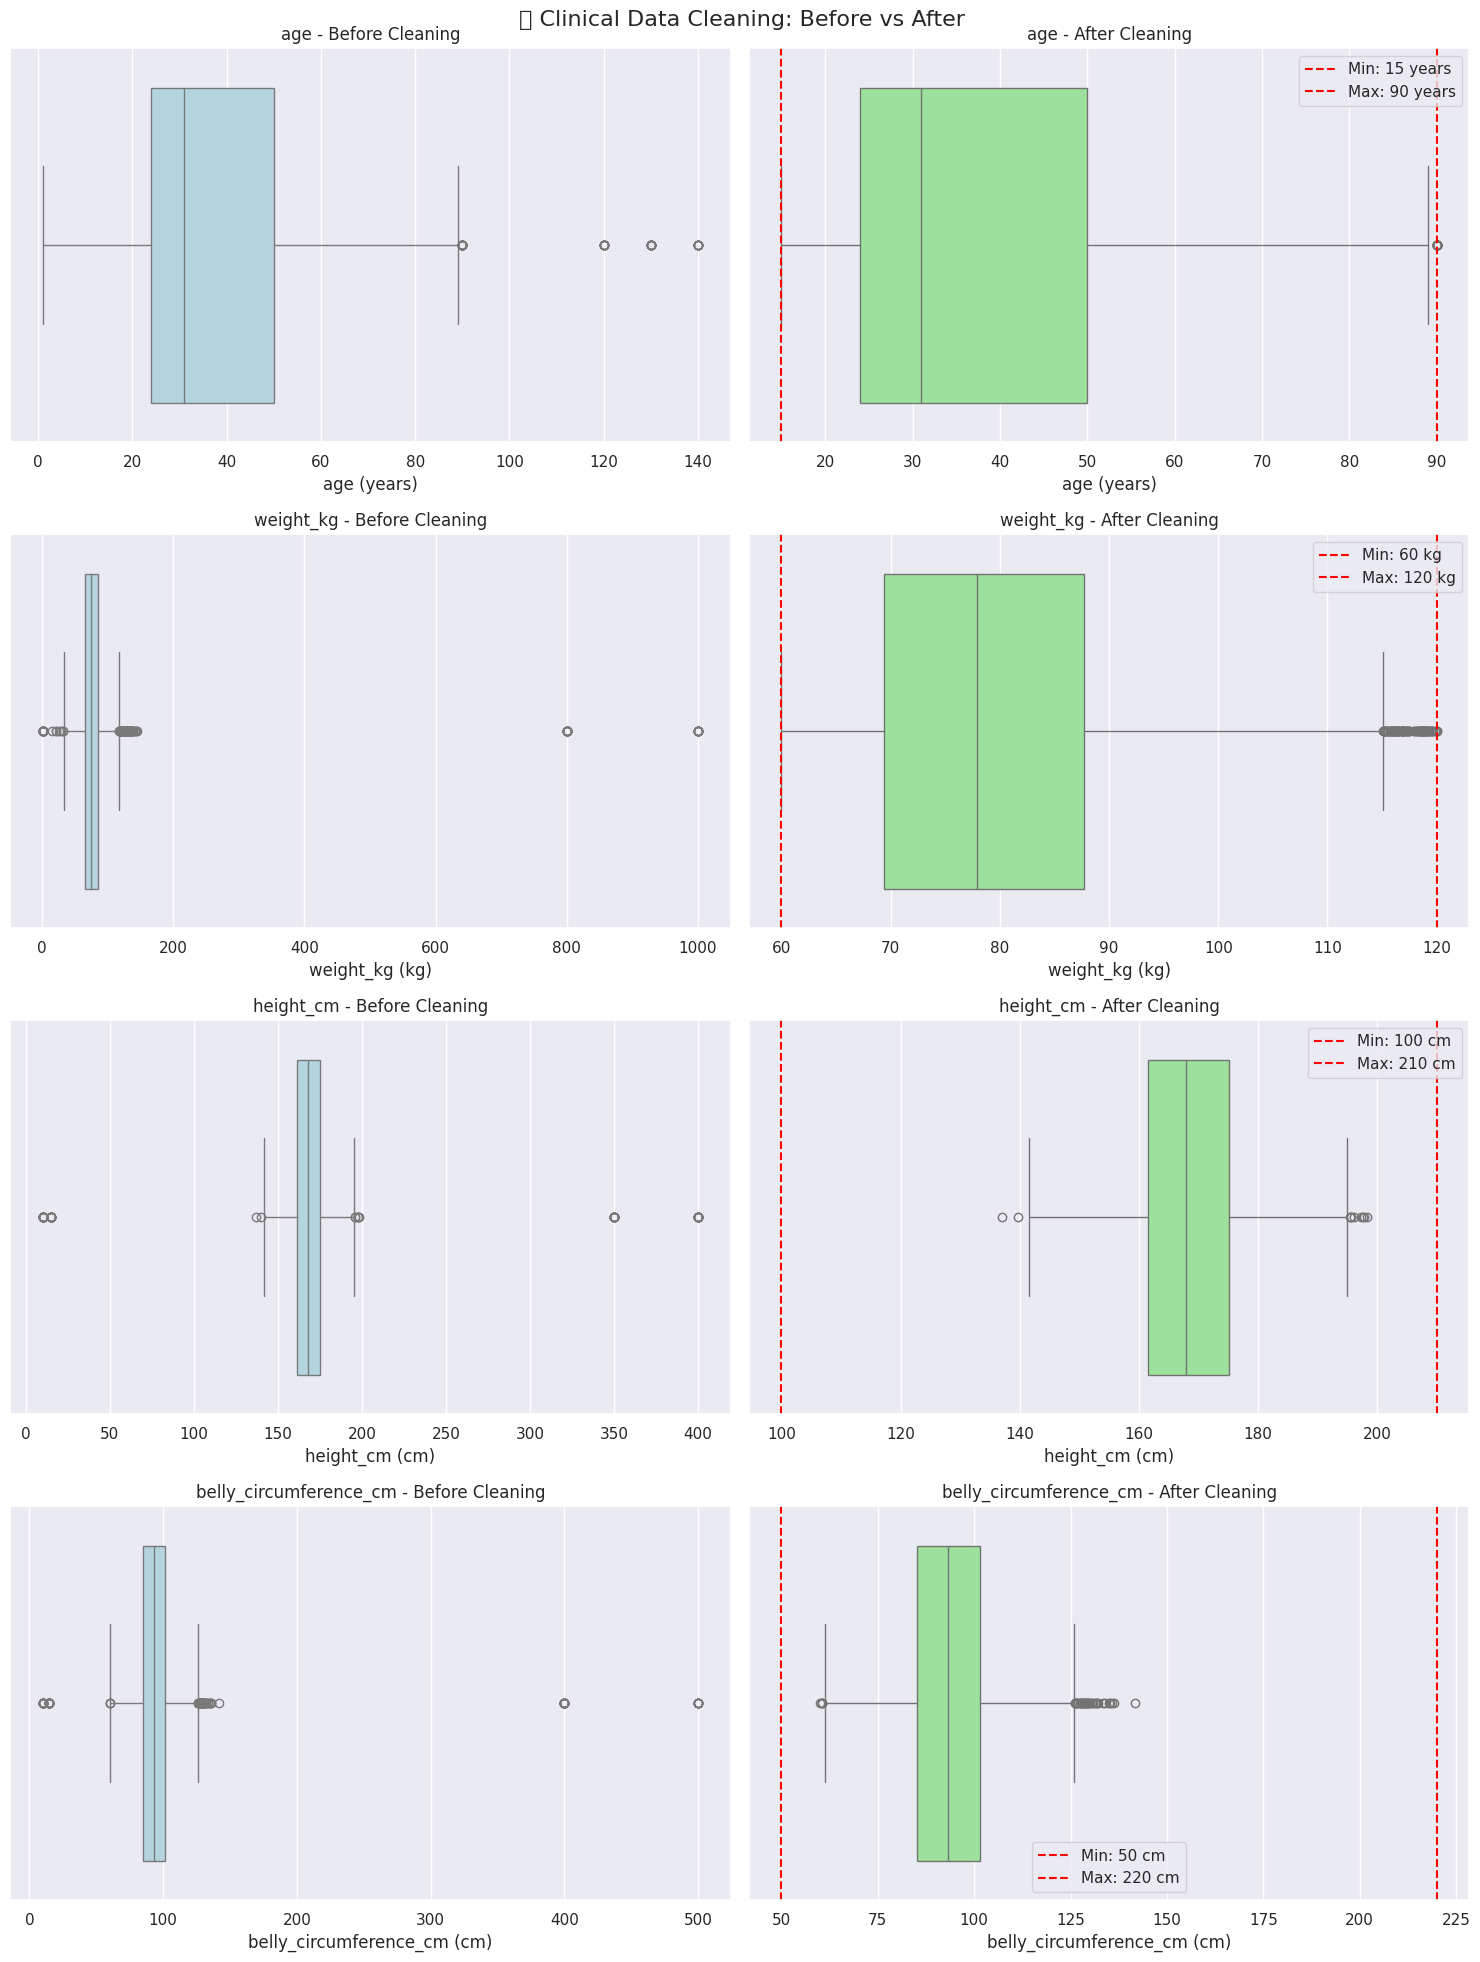


📋 Cleaning Summary:
Initial records: 14,000

Removed records by feature:
- age: 69 records (0.5%)
- weight_kg: 2,681 records (19.1%)
- height_cm: 479 records (3.4%)
- belly_circumference_cm: 475 records (3.4%)

Final records: 10,486
Total removed: 3,514 (25.1%)

📊 Testing Data Cleaning
🧹 Starting data cleaning process...

🔍 Cleaning age:
Valid range: 15-90 years
Reason: Valid adult age range for hypertension study
⚠️ Removed 31 records outside clinical range
Invalid values found:
min      1.0
max    140.0

🔍 Cleaning weight_kg:
Valid range: 60-120 kg
Reason: Normal adult weight range
⚠️ Removed 1,227 records outside clinical range
Invalid values found:
min       1.0
max    1000.0

🔍 Cleaning height_cm:
Valid range: 100-210 cm
Reason: Normal adult height range
⚠️ Removed 202 records outside clinical range
Invalid values found:
min     10.0
max    400.0

🔍 Cleaning belly_circumference_cm:
Valid range: 50-220 cm
Reason: Normal adult waist circumference range
⚠️ Removed 225 records outsid

<ipython-input-3-ad6b45dd7b6f>:104: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


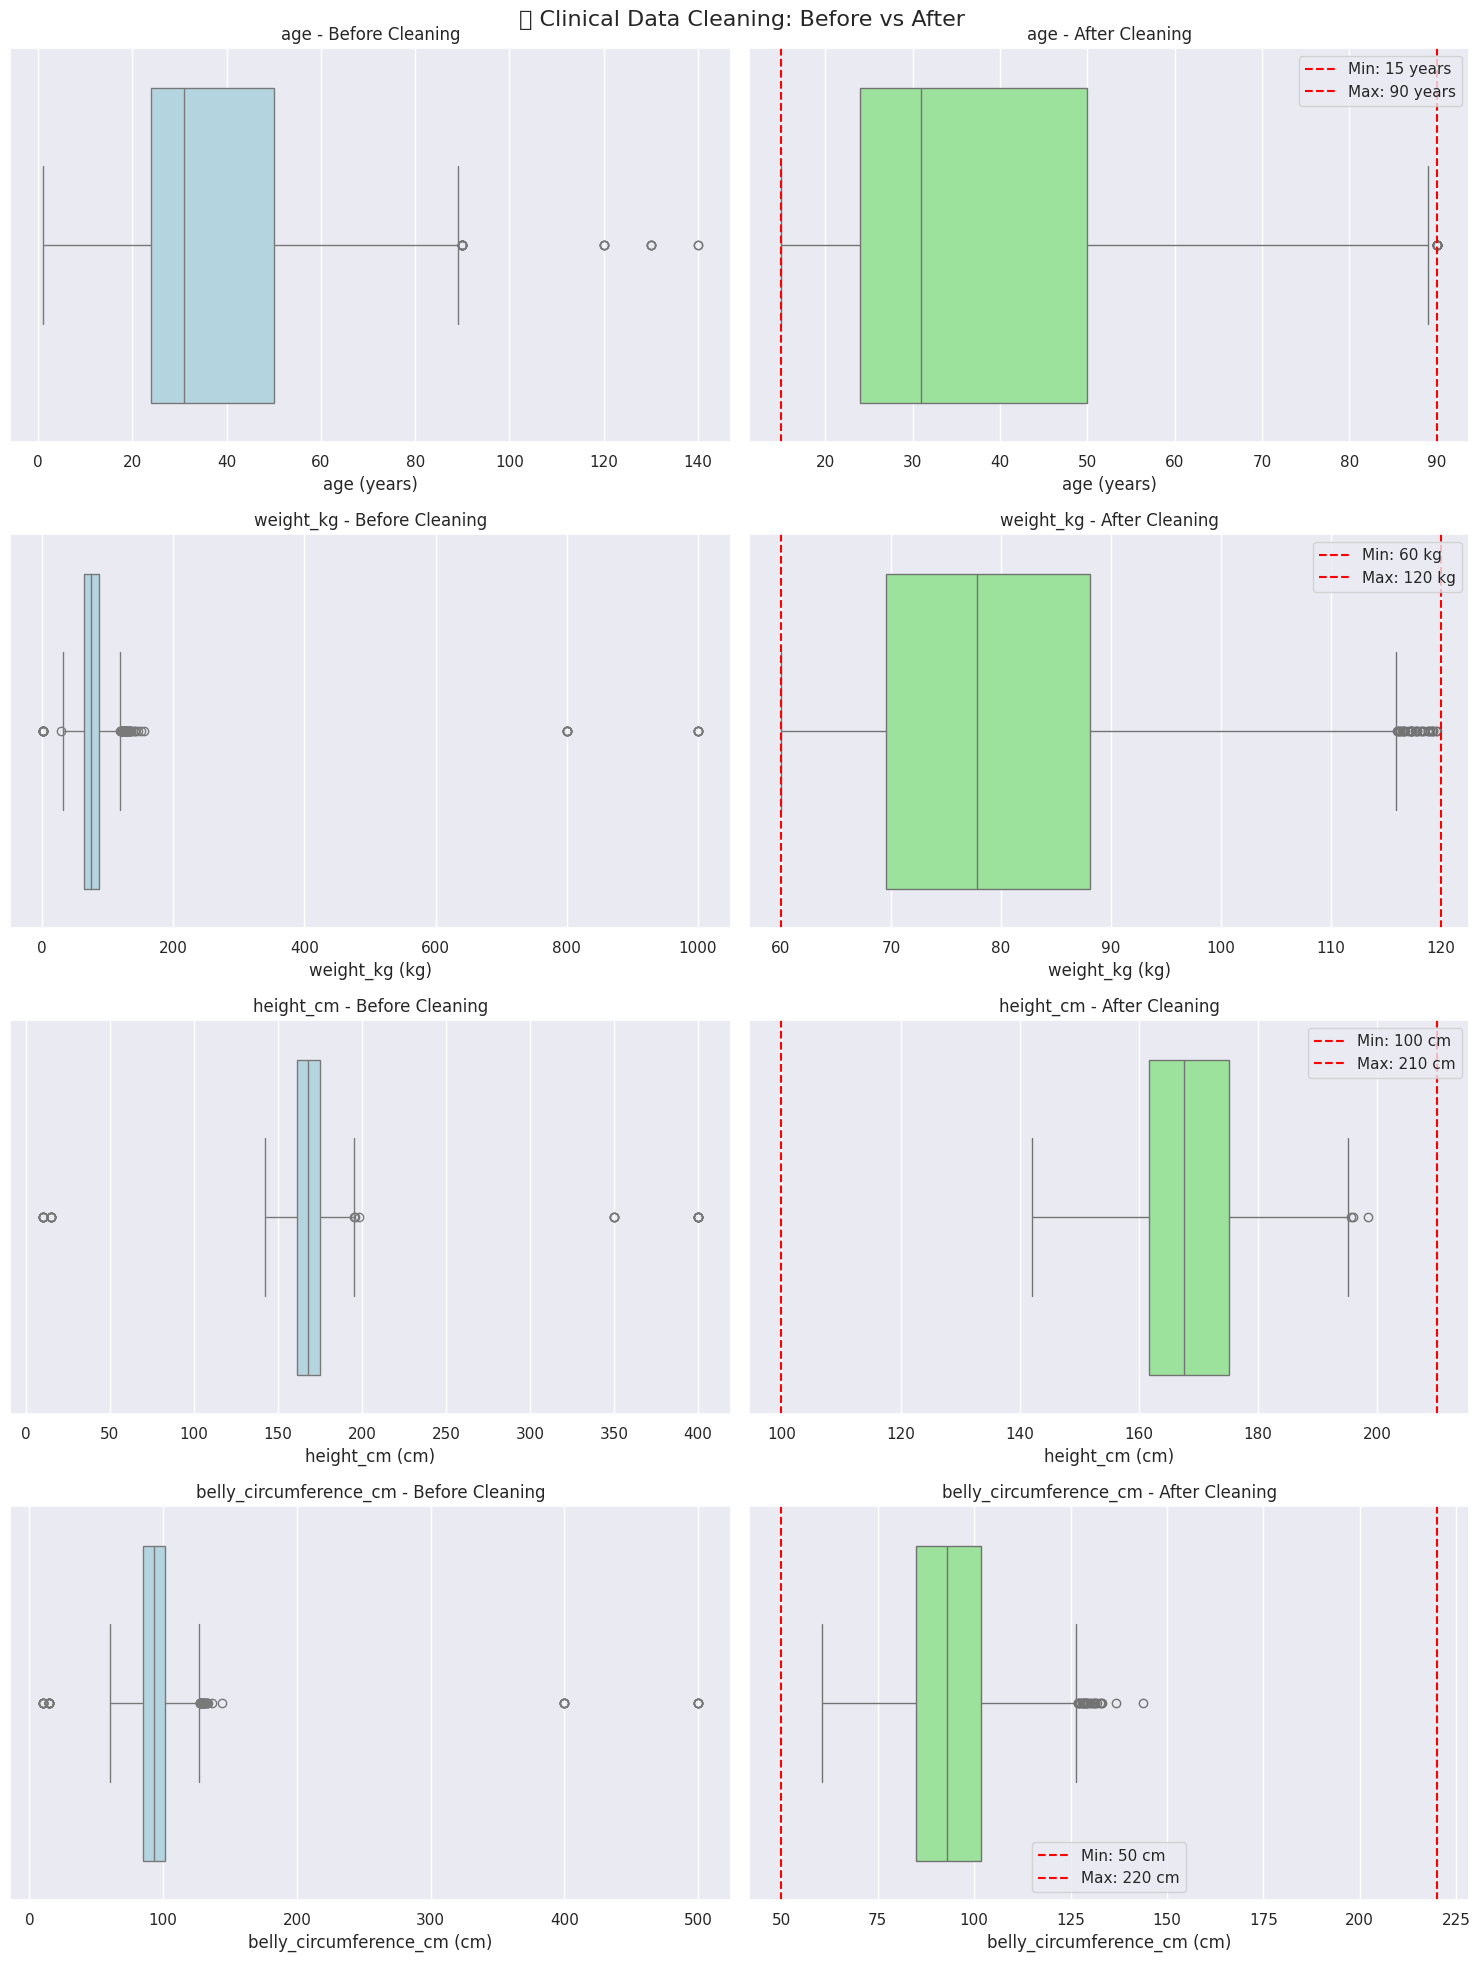


📋 Cleaning Summary:
Initial records: 6,000

Removed records by feature:
- age: 31 records (0.5%)
- weight_kg: 1,227 records (20.4%)
- height_cm: 202 records (3.4%)
- belly_circumference_cm: 225 records (3.8%)

Final records: 4,417
Total removed: 1,583 (26.4%)


In [3]:
def clean_anomalies_clinical(df: pd.DataFrame, visualize: bool = True) -> pd.DataFrame:
    """
    Clean the dataset by removing clinically impossible values and visualize the cleaning process.

    Parameters:
    -----------
    df : pd.DataFrame
        Input dataset containing medical measurements
    visualize : bool, optional (default=True)
        Whether to show before/after visualizations

    Returns:
    --------
    pd.DataFrame
        Cleaned dataset with only clinically valid values
    """
    print("🧹 Starting data cleaning process...")
    df_cleaned = df.copy()

    # Define clinical thresholds with detailed medical context
    clinical_thresholds = {
        'age': {
            'min': 15, 'max': 90,
            'reason': 'Valid adult age range for hypertension study',
            'unit': 'years'
        },
        'weight_kg': {
            'min': 60, 'max': 120,
            'reason': 'Normal adult weight range',
            'unit': 'kg'
        },
        'height_cm': {
            'min': 100, 'max': 210,
            'reason': 'Normal adult height range',
            'unit': 'cm'
        },
        'belly_circumference_cm': {
            'min': 50, 'max': 220,
            'reason': 'Normal adult waist circumference range',
            'unit': 'cm'
        }
    }

    # Create visualization grid
    if visualize:
        fig, axs = plt.subplots(len(clinical_thresholds), 2,
                               figsize=(15, 5*len(clinical_thresholds)))
        fig.suptitle("📊 Clinical Data Cleaning: Before vs After", fontsize=16)

    # Track cleaning statistics
    cleaning_stats = {
        'total_records': len(df),
        'removed_records': {},
        'final_records': 0
    }

    # Process each measurement
    mask = pd.Series(True, index=df_cleaned.index)
    for i, (col, limits) in enumerate(clinical_thresholds.items()):
        print(f"\n🔍 Cleaning {col}:")
        print(f"Valid range: {limits['min']}-{limits['max']} {limits['unit']}")
        print(f"Reason: {limits['reason']}")

        # Convert to numeric and handle missing values
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

        if visualize:
            # Before cleaning plot
            sns.boxplot(x=df_cleaned[col].dropna(), ax=axs[i, 0], color='lightblue')
            axs[i, 0].set_title(f'{col} - Before Cleaning')
            axs[i, 0].set_xlabel(f'{col} ({limits["unit"]})')

        # Apply clinical thresholds
        col_mask = (df_cleaned[col] >= limits['min']) & (df_cleaned[col] <= limits['max'])
        invalid_count = (~col_mask).sum()
        cleaning_stats['removed_records'][col] = invalid_count

        if invalid_count > 0:
            print(f"⚠️ Removed {invalid_count:,} records outside clinical range")
            print("Invalid values found:")
            print(df_cleaned[~col_mask][col].describe()[['min', 'max']].to_string())

        mask &= col_mask

        if visualize:
            # After cleaning plot
            valid_data = df_cleaned.loc[col_mask, col]
            sns.boxplot(x=valid_data.dropna(), ax=axs[i, 1], color='lightgreen')
            axs[i, 1].set_title(f'{col} - After Cleaning')
            axs[i, 1].set_xlabel(f'{col} ({limits["unit"]})')

            # Add threshold lines
            axs[i, 1].axvline(x=limits['min'], color='red', linestyle='--',
                             label=f'Min: {limits["min"]} {limits["unit"]}')
            axs[i, 1].axvline(x=limits['max'], color='red', linestyle='--',
                             label=f'Max: {limits["max"]} {limits["unit"]}')
            axs[i, 1].legend()

    # Apply final cleaning
    df_cleaned = df_cleaned[mask]
    cleaning_stats['final_records'] = len(df_cleaned)

    if visualize:
        plt.tight_layout()
        plt.show()

    # Print final cleaning summary
    print("\n📋 Cleaning Summary:")
    print(f"Initial records: {cleaning_stats['total_records']:,}")
    print("\nRemoved records by feature:")
    for col, count in cleaning_stats['removed_records'].items():
        print(f"- {col}: {count:,} records ({(count/cleaning_stats['total_records'])*100:.1f}%)")
    print(f"\nFinal records: {cleaning_stats['final_records']:,}")
    print(f"Total removed: {cleaning_stats['total_records'] - cleaning_stats['final_records']:,} "
          f"({((cleaning_stats['total_records'] - cleaning_stats['final_records'])/cleaning_stats['total_records'])*100:.1f}%)")

    return df_cleaned

# Example usage with clear section headers
print("="*50)
print("🏥 CLINICAL DATA CLEANING")
print("="*50)

print("\n📊 Training Data Cleaning")
df_train_cleaned = clean_anomalies_clinical(df_train)

print("\n📊 Testing Data Cleaning")
df_test_cleaned = clean_anomalies_clinical(df_test)

In [4]:
df_train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10486 entries, 0 to 13999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      10486 non-null  int64  
 1   age                     10486 non-null  int64  
 2   gender                  10281 non-null  object 
 3   height_cm               10486 non-null  float64
 4   weight_kg               10486 non-null  float64
 5   belly_circumference_cm  10486 non-null  float64
 6   smoking_status          10150 non-null  object 
 7   exercise_frequency      9731 non-null   object 
 8   salt_consumption        9919 non-null   object 
 9   sugar_consumption       9987 non-null   object 
 10  self_emotional          1050 non-null   float64
 11  family_history          10154 non-null  float64
 12  label_hypertension      10486 non-null  int64  
 13  input_time              10486 non-null  object 
dtypes: float64(5), int64(3), object(6)
memory u

# 4. Prevalence Analysis

After cleaning our data based on clinical thresholds, let's examine the prevalence of hypertension in our cleaned datasets.

🔍 ANALYZING TRAINING DATASET


<ipython-input-5-2b207b25b481>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Non-Hypertensive', 'Hypertensive'],
<ipython-input-5-2b207b25b481>:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count = gender_counts[i]


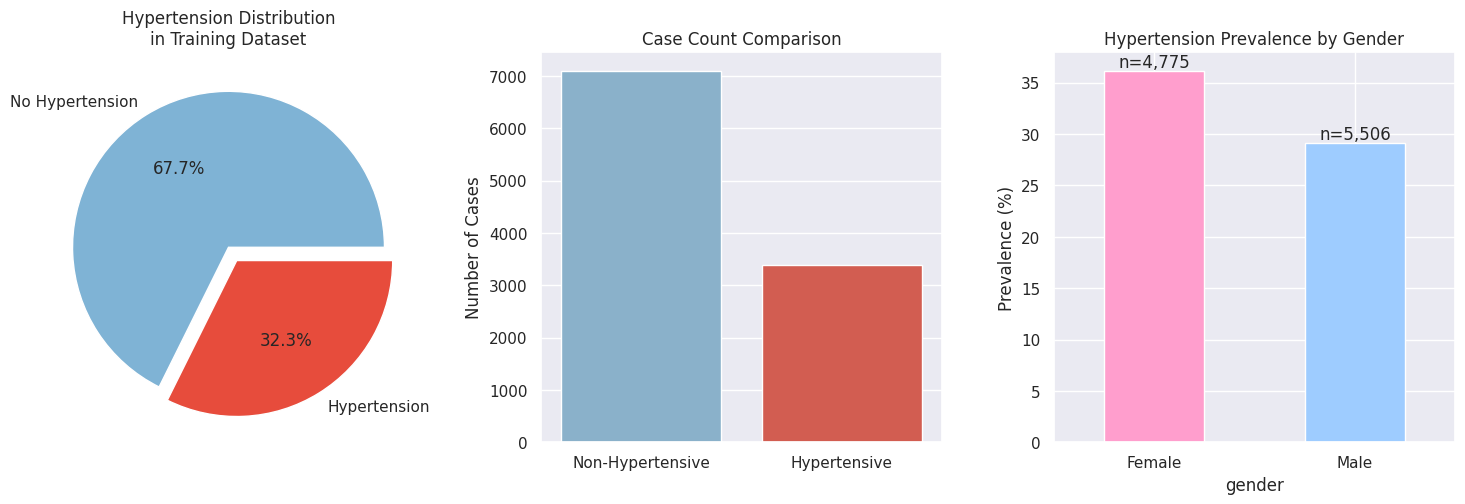


📊 Prevalence Analysis for Training Dataset:
Total Samples: 10,486
Hypertension Cases: 3,391
Overall Prevalence Rate: 32.3%

📈 Prevalence by Gender:
- Female: 36.1% (n=4,775)
- Male: 29.1% (n=5,506)

🔍 ANALYZING TESTING DATASET


<ipython-input-5-2b207b25b481>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Non-Hypertensive', 'Hypertensive'],
<ipython-input-5-2b207b25b481>:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count = gender_counts[i]


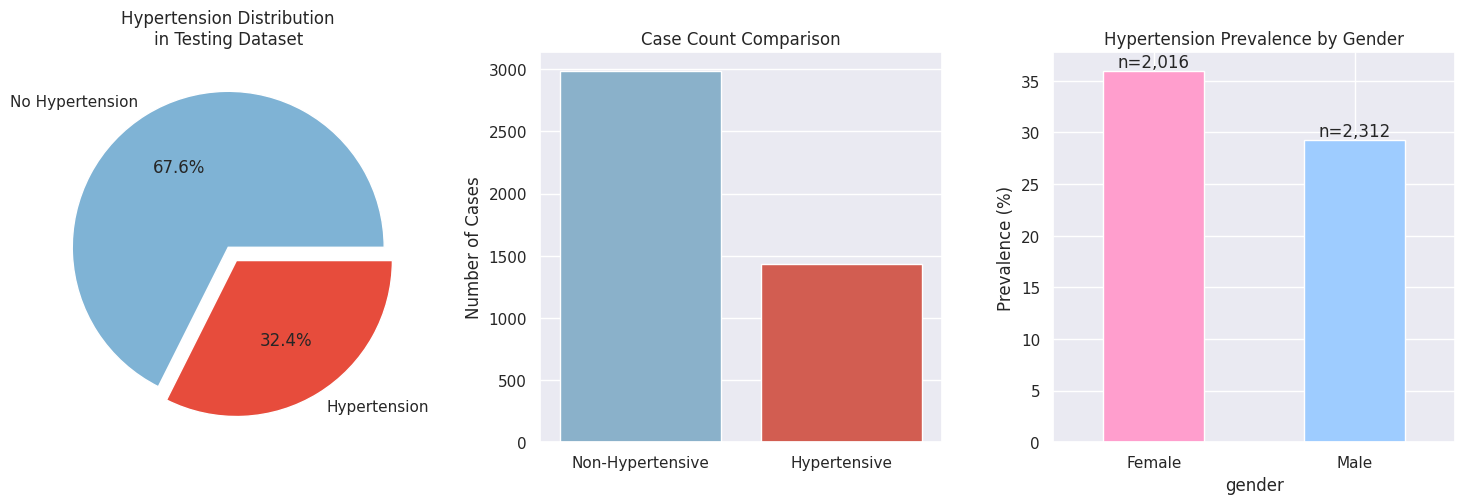


📊 Prevalence Analysis for Testing Dataset:
Total Samples: 4,417
Hypertension Cases: 1,431
Overall Prevalence Rate: 32.4%

📈 Prevalence by Gender:
- Female: 36.0% (n=2,016)
- Male: 29.3% (n=2,312)

📋 DATASET COMPARISON:
Training vs Testing Prevalence Difference: 0.1%


In [5]:
def analyze_prevalence(df: pd.DataFrame,
                      dataset_name: str = "Dataset",
                      demographic_features: List[str] = None) -> dict:
    """
    Analyze and visualize hypertension prevalence in the dataset.

    Parameters:
    -----------
    df : pd.DataFrame
        Dataset containing 'label_hypertension' column
    dataset_name : str, optional
        Name of the dataset for display purposes
    demographic_features : List[str], optional
        List of features to analyze prevalence across (e.g., ['gender'])
    """
    # Calculate overall prevalence
    total_samples = len(df)
    hypertension_cases = df['label_hypertension'].sum()
    prevalence_rate = (hypertension_cases / total_samples) * 100

    # Store statistics
    stats = {
        'total_samples': total_samples,
        'hypertension_cases': hypertension_cases,
        'prevalence_rate': prevalence_rate
    }

    # Create visualization figure
    fig = plt.figure(figsize=(15, 5))

    # 1. Pie Chart
    plt.subplot(131)
    labels = ['No Hypertension', 'Hypertension']
    sizes = [(total_samples - hypertension_cases), hypertension_cases]
    colors = ['#7FB3D5', '#E74C3C']  # Light blue and red

    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors,
            explode=(0, 0.1))  # Explode hypertension slice
    plt.title(f'Hypertension Distribution\nin {dataset_name}')

    # 2. Bar Plot
    plt.subplot(132)
    sns.barplot(x=['Non-Hypertensive', 'Hypertensive'],
                y=[sizes[0], sizes[1]],
                palette=colors)
    plt.title('Case Count Comparison')
    plt.ylabel('Number of Cases')

    # 3. Gender-based analysis
    if demographic_features and 'gender' in demographic_features:
        plt.subplot(133)

        # Calculate prevalence by gender (percentage of hypertension cases in each gender)
        prev_by_gender = df.groupby('gender')['label_hypertension'].mean() * 100
        gender_counts = df.groupby('gender').size()

        # Create bar plot
        ax = prev_by_gender.plot(kind='bar', color=['#FF9ECD', '#9ECCFF'])
        plt.title('Hypertension Prevalence by Gender')
        plt.ylabel('Prevalence (%)')
        plt.xticks(rotation=0)

        # Add count annotations on bars
        for i, v in enumerate(prev_by_gender):
            count = gender_counts[i]
            ax.text(i, v, f'n={count:,}', ha='center', va='bottom')

        # Store gender statistics
        stats['gender_prevalence'] = prev_by_gender.to_dict()
        stats['gender_counts'] = gender_counts.to_dict()

    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print(f"\n📊 Prevalence Analysis for {dataset_name}:")
    print("="*50)
    print(f"Total Samples: {total_samples:,}")
    print(f"Hypertension Cases: {hypertension_cases:,}")
    print(f"Overall Prevalence Rate: {prevalence_rate:.1f}%")

    if demographic_features and 'gender' in demographic_features:
        print(f"\n📈 Prevalence by Gender:")
        for gender, rate in stats['gender_prevalence'].items():
            count = stats['gender_counts'][gender]
            print(f"- {gender}: {rate:.1f}% (n={count:,})")

    return stats

# Execute the analysis
demographic_features = ['gender']

# Analyze training dataset
print("🔍 ANALYZING TRAINING DATASET")
train_stats = analyze_prevalence(
    df=df_train_cleaned,
    dataset_name="Training Dataset",
    demographic_features=demographic_features
)

# Analyze testing dataset
print("\n🔍 ANALYZING TESTING DATASET")
test_stats = analyze_prevalence(
    df=df_test_cleaned,
    dataset_name="Testing Dataset",
    demographic_features=demographic_features
)

# Simple dataset comparison
print("\n📋 DATASET COMPARISON:")
print("="*50)
train_prev = train_stats['prevalence_rate']
test_prev = test_stats['prevalence_rate']
print(f"Training vs Testing Prevalence Difference: {abs(train_prev - test_prev):.1f}%")

# 5. Analysis Missing Values

Understanding missing values in our dataset is crucial for data preprocessing and ensuring model quality.

🔍 MISSING VALUES ANALYSIS

📊 Missing Values Analysis for Training Dataset:

🔍 Features with Missing Values:


,Missing Values,Percentage (%)
self_emotional,9436,89.99
exercise_frequency,755,7.20
salt_consumption,567,5.41
sugar_consumption,499,4.76
smoking_status,336,3.20
family_history,332,3.17
gender,205,1.95



📈 Summary Statistics:
Total missing values: 12,130
Features with missing values: 7
Most affected feature: self_emotional (90.0%)


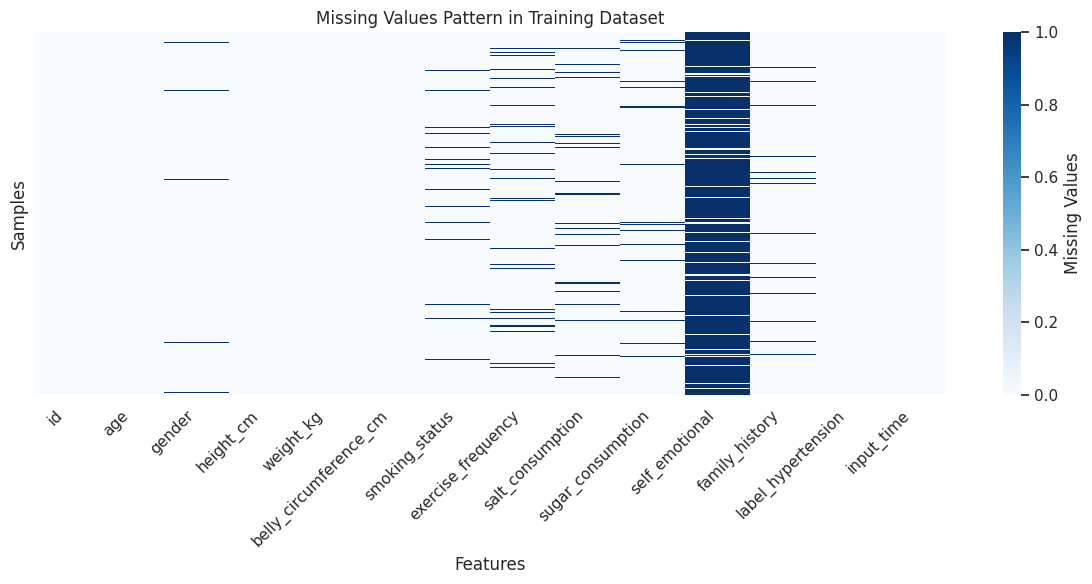




📊 Missing Values Analysis for Testing Dataset:

🔍 Features with Missing Values:


,Missing Values,Percentage (%)
self_emotional,3995,90.45
exercise_frequency,295,6.68
sugar_consumption,252,5.71
salt_consumption,218,4.94
family_history,133,3.01
smoking_status,130,2.94
gender,89,2.01



📈 Summary Statistics:
Total missing values: 5,112
Features with missing values: 7
Most affected feature: self_emotional (90.5%)


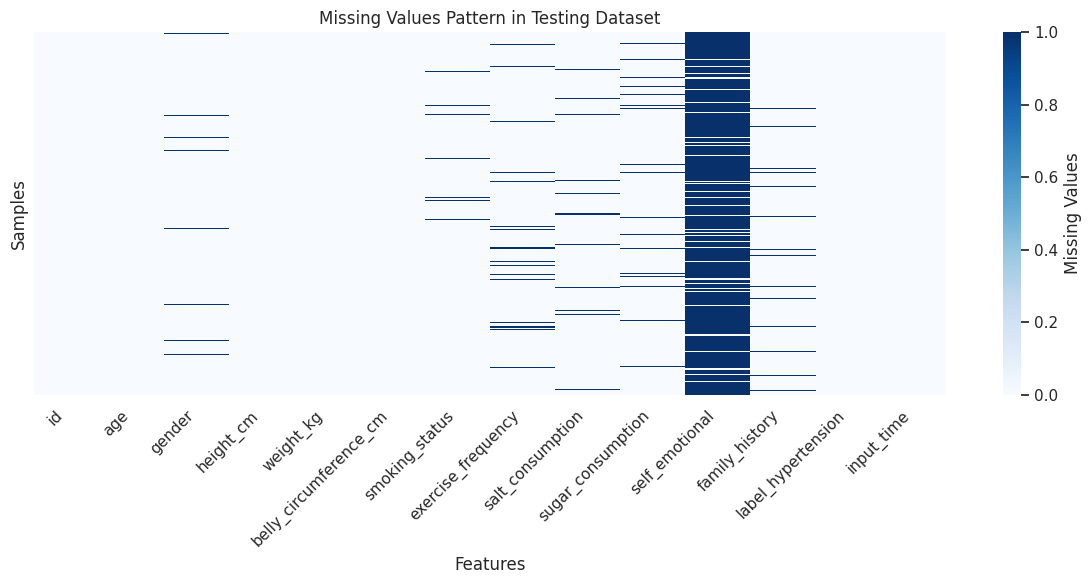

In [6]:
def analyze_missing_values(df: pd.DataFrame, dataset_name: str = "Dataset") -> None:
    """
    Analyze and visualize missing values in the dataset.

    Parameters:
    -----------
    df : pd.DataFrame
        Dataset to analyze
    dataset_name : str
        Name of the dataset for display purposes
    """
    # Calculate missing values
    missing = df.isnull().sum()
    missing_percent = (missing / len(df) * 100).round(2)

    # Create summary DataFrame for missing values
    missing_summary = pd.DataFrame({
        'Missing Values': missing,
        'Percentage (%)': missing_percent
    })

    # Sort by percentage of missing values
    missing_summary = missing_summary[missing_summary['Missing Values'] > 0].sort_values(
        'Percentage (%)',
        ascending=False
    )

    print(f"\n📊 Missing Values Analysis for {dataset_name}:")
    print("="*50)

    if len(missing_summary) > 0:
        # Style and display the summary
        print("\n🔍 Features with Missing Values:")
        display(missing_summary)

        # Print additional statistics
        total_missing = missing.sum()
        features_with_missing = len(missing_summary)
        print(f"\n📈 Summary Statistics:")
        print(f"Total missing values: {total_missing:,}")
        print(f"Features with missing values: {features_with_missing}")

        # Most affected feature
        most_missing = missing_summary.iloc[0]
        print(f"Most affected feature: {most_missing.name} ({most_missing['Percentage (%)']:.1f}%)")

        # Visualize missing values patterns
        plt.figure(figsize=(12, 6))

        # Create heatmap with custom colormap
        sns.heatmap(df.isnull(),
                   yticklabels=False,
                   cmap='Blues',
                   cbar=True,
                   cbar_kws={'label': 'Missing Values'})

        plt.title(f'Missing Values Pattern in {dataset_name}')
        plt.xlabel('Features')
        plt.ylabel('Samples')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    else:
        print("✅ No missing values found!")

# Analyze missing values in both datasets
print("="*50)
print("🔍 MISSING VALUES ANALYSIS")
print("="*50)

# Analyze training dataset
analyze_missing_values(df_train_cleaned, "Training Dataset")

# Add separator between analyses
print("\n" + "="*70 + "\n")

# Analyze testing dataset
analyze_missing_values(df_test_cleaned, "Testing Dataset")

# 6. Data Preprocessing
First, let's prepare our features by separating categorical and numerical variables, and creating our target variable.

In [7]:
def create_preprocessing_pipeline(categorical_features: List[str],
                                numeric_features: List[str]) -> Pipeline:
    """
    Create a preprocessing pipeline for both categorical and numeric features.
    """
    # Numeric features pipeline
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Categorical features pipeline
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False))
    ])

    # Combine transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    return preprocessor

def prepare_and_preprocess_data(df: pd.DataFrame, random_state: int = 42) -> Tuple:
    """
    Prepare and preprocess training data
    """
    categorical_features = [
        'gender',
        'sugar_consumption',
        'salt_consumption',
        'exercise_frequency',
        'smoking_status',
        'family_history'
    ]

    numeric_features = [
        'age',
        'weight_kg',
        'height_cm',
        'belly_circumference_cm'
    ]

    # Create preprocessing pipeline
    preprocessor = create_preprocessing_pipeline(categorical_features, numeric_features)

    # Split training data into train and validation sets
    X_full = df[categorical_features + numeric_features]
    y_full = df['label_hypertension']

    X_train, X_val, y_train, y_val = train_test_split(
        X_full,
        y_full,
        test_size=0.3,
        random_state=random_state,
        stratify=y_full
    )

    # Store original values before preprocessing for demonstration
    original_values = X_train.iloc[:5][numeric_features].copy()

    # Fit preprocessor on training data and transform both sets
    X_train_processed = preprocessor.fit_transform(X_train)
    X_val_processed = preprocessor.transform(X_val)

    # Get feature names after preprocessing
    numeric_features_out = numeric_features

    # Get categorical feature names after one-hot encoding
    cat_features_out = []
    for i, feature in enumerate(categorical_features):
        encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
        categories = encoder.categories_[i][1:]
        cat_features_out.extend([f"{feature}_{cat}" for cat in categories])

    # Combine all feature names
    feature_names = numeric_features_out + cat_features_out

    # Get scaler parameters for demonstration
    scaler = preprocessor.named_transformers_['num'].named_steps['scaler']
    means = dict(zip(numeric_features, scaler.mean_))
    stds = dict(zip(numeric_features, scaler.scale_))

    # Print informative messages
    print("✅ Data Processing Complete!")
    print("\n📊 Dataset Shapes:")
    print(f"Training set: {X_train_processed.shape}")
    print(f"Validation set: {X_val_processed.shape}")

    print("\n📋 Selected Features:")
    print("\nCategorical Features:")
    for f in categorical_features:
        print(f"- {f}")
    print("\nNumeric Features:")
    for f in numeric_features:
        print(f"- {f}")

    # Show standardization example
    print("\n📈 Understanding Standardization (Standard Scaling):")
    print("Formula: z = (x - μ) / σ")
    print("Where:")
    print("- z is the standardized value")
    print("- x is the original value")
    print("- μ (mu) is the mean")
    print("- σ (sigma) is the standard deviation")

    # Show example calculations for first feature only
    feature = numeric_features[0]
    print(f"\n🔍 Example with {feature.upper()}:")
    print(f"Mean (μ): {means[feature]:.1f}")
    print(f"Standard Deviation (σ): {stds[feature]:.1f}")

    # Show one example calculation
    original = original_values[feature].iloc[0]
    scaled = pd.DataFrame(X_train_processed[:1], columns=feature_names)[feature].iloc[0]

    print(f"\nExample calculation:")
    print(f"Original value: {original:.1f}")
    print(f"Scaled value: {scaled:.3f}")
    print(f"1. (x - μ): {original:.1f} - {means[feature]:.1f} = {original - means[feature]:.1f}")
    print(f"2. (x - μ) / σ: {original - means[feature]:.1f} / {stds[feature]:.1f} = {scaled:.3f}")

    # Display class distribution
    print("\n📊 Class Distribution:")
    for name, y_data in [("Training", y_train), ("Validation", y_val)]:
        dist = pd.Series(y_data).value_counts(normalize=True) * 100
        print(f"\n{name} Set:")
        for label, percentage in dist.items():
            print(f"Class {label}: {percentage:.1f}%")

    return (X_train_processed, X_val_processed,
            y_train, y_val,
            feature_names, preprocessor)

# Execute preprocessing
print("="*50)
print("🛠️ DATA PREPROCESSING")
print("="*50)

# Process training data with selected features
(X_train_processed, X_val_processed,
 y_train, y_val,
 feature_names, preprocessor) = prepare_and_preprocess_data(df_train_cleaned)

# Display sample of processed features
print("\n📋 Sample of Processed Features:")
sample_df = pd.DataFrame(
    X_train_processed[:5],
    columns=feature_names
)
display(sample_df.round(3))

🛠️ DATA PREPROCESSING
✅ Data Processing Complete!

📊 Dataset Shapes:
Training set: (7340, 11)
Validation set: (3146, 11)

📋 Selected Features:

Categorical Features:
- gender
- sugar_consumption
- salt_consumption
- exercise_frequency
- smoking_status
- family_history

Numeric Features:
- age
- weight_kg
- height_cm
- belly_circumference_cm

📈 Understanding Standardization (Standard Scaling):
Formula: z = (x - μ) / σ
Where:
- z is the standardized value
- x is the original value
- μ (mu) is the mean
- σ (sigma) is the standard deviation

🔍 Example with AGE:
Mean (μ): 36.5
Standard Deviation (σ): 16.6

Example calculation:
Original value: 49.0
Scaled value: 0.756
1. (x - μ): 49.0 - 36.5 = 12.5
2. (x - μ) / σ: 12.5 / 16.6 = 0.756

📊 Class Distribution:

Training Set:
Class 0: 67.7%
Class 1: 32.3%

Validation Set:
Class 0: 67.7%
Class 1: 32.3%

📋 Sample of Processed Features:


,age,weight_kg,height_cm,belly_circumference_cm,gender_Male,sugar_consumption_low,salt_consumption_low,exercise_frequency_low,smoking_status_quit,smoking_status_smoker,family_history_1.0
0,0.756,1.399,1.438,-0.161,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-1.294,-1.178,-1.144,0.082,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-1.233,-0.579,-1.751,0.054,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-1.173,0.934,-0.031,0.624,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,-1.233,-0.814,-1.656,-0.163,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# !Usefull function

In [8]:
def save_model(pipeline, save_dir='/content/drive/MyDrive/Colab/hypertension_risk/model',
               model_name='hypertension_model'):
    """
    Save trained model with simple datetime versioning to Google Drive.

    Parameters:
    -----------
    pipeline : Pipeline
        Trained model pipeline to save
    save_dir : str
        Directory path in Google Drive
    model_name : str
        Name for the model file
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Add timestamp to filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    filename = f"{model_name}_{timestamp}.joblib"
    save_path = os.path.join(save_dir, filename)

    # Save the model
    try:
        joblib.dump(pipeline, save_path)
        print(f"Model saved successfully!")
        print(f"Location: {save_path}")

        # List saved models in the directory
        print("\nSaved models in directory:")
        for file in os.listdir(save_dir):
            if file.endswith('.joblib'):
                print(f"- {file}")

    except Exception as e:
        print(f"Error saving model: {str(e)}")

def load_model(filename, load_dir='/content/drive/MyDrive/Colab/hypertension_risk/model'):
    """
    Load a saved model from Google Drive.

    Parameters:
    -----------
    filename : str
        Name of the model file to load
    load_dir : str
        Directory path in Google Drive
    """
    try:
        model_path = os.path.join(load_dir, filename)
        model = joblib.load(model_path)
        print(f"Model loaded successfully: {filename}")
        return model
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return None


# 7. Model Development
Now we'll create our LightGBM model with a preprocessing pipeline that handles both numerical and categorical features.

In [9]:
print("="*50)
print("🚀 MODEL DEVELOPMENT")
print("="*50)

def create_model(X_train, y_train, X_val, y_val, feature_names):
    """
    Creates and trains a LightGBM model with more robust configuration
    to prevent overfitting
    """
    # Calculate class weights
    n_negative = len(y_train[y_train == 0])
    n_positive = len(y_train[y_train == 1])
    scale_pos_weight = n_negative / n_positive

    print(f"\n📊 Class Balance:")
    print(f"Negative cases: {n_negative}")
    print(f"Positive cases: {n_positive}")
    print(f"Scale pos weight: {scale_pos_weight:.2f}")

    # Model parameters
    model_params = {
        # Type of boosting algorithm to use
        # 'gbdt' (Gradient Boosting Decision Tree) is the traditional gradient boosting
        'boosting_type': 'gbdt',

        # Define the task as binary classification
        # For predicting two classes (0 or 1)
        'objective': 'binary',

        # Maximum number of trees/iterations
        # Higher values may improve performance but increase training time
        'n_estimators': 1000,

        # Step size of each iteration
        # Smaller values make the model more robust but require more iterations
        'learning_rate': 0.01,

        # Maximum number of leaves in one tree
        # Controls the complexity of each tree
        # Lower values reduce overfitting
        'num_leaves': 20,

        # Maximum depth of each tree
        # Limits how deep each tree can grow
        # Lower values help prevent overfitting
        'max_depth': 4,

        # Minimum number of samples required to create a leaf
        # Higher values prevent creating too specialized leaves
        # Helps control overfitting
        'min_data_in_leaf': 20,

        # Fraction of features to consider at each tree iteration
        # Value < 1.0 introduces randomness and reduces overfitting
        # 0.8 means each tree will randomly select 80% of features
        'feature_fraction': 0.8,

        # Fraction of data to use for each tree
        # Similar to feature_fraction but for data rows
        # 0.8 means each tree will use 80% of the training data
        'bagging_fraction': 0.8,

        # Frequency for bagging
        # 1 means perform bagging at every iteration
        'bagging_freq': 1,

        # L1 regularization term (Lasso)
        # Helps with feature selection and prevents overfitting
        # Higher values create more conservative models
        'lambda_l1': 0.1,

        # L2 regularization term (Ridge)
        # Prevents coefficients from getting too large
        # Higher values create more conservative models
        'lambda_l2': 0.1,

        # Adjusts weights of positive class
        # Helps handle class imbalance
        # Value calculated as (number of negative cases) / (number of positive cases)
        'scale_pos_weight': scale_pos_weight,

        # Seed for random number generation
        # Ensures reproducibility of results
        'random_state': 42,

        # Control logging output
        # -1 means no logging output
        'verbose': -1
    }

    print("\n⚙️ Model Configuration:")
    for param, value in model_params.items():
        print(f"{param}: {value}")

    try:
        model = LGBMClassifier(**model_params)

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            eval_metric=['auc', 'binary_logloss'],
            callbacks=[
                early_stopping(stopping_rounds=50),
                log_evaluation(period=100)
            ]
        )

        return model

    except Exception as e:
        print(f"⚠️ Training failed with error: {str(e)}")
        return None

# Cross-validation
print("\n📊 Cross-validation Results:")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_train = []
cv_scores_val = []
best_score = 0
model = None  # Initialize model variable

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_processed)):
    print(f"\nTraining Fold {fold + 1}/5")
    X_fold_train = X_train_processed[train_idx]
    y_fold_train = y_train.iloc[train_idx]
    X_fold_val = X_train_processed[val_idx]
    y_fold_val = y_train.iloc[val_idx]

    fold_model = create_model(
        X_fold_train, y_fold_train,
        X_fold_val, y_fold_val,
        feature_names
    )

    if fold_model is not None:
        # Calculate training AUC
        train_pred = fold_model.predict_proba(X_fold_train)[:, 1]
        train_score = roc_auc_score(y_fold_train, train_pred)
        cv_scores_train.append(train_score)

        # Calculate validation AUC
        val_pred = fold_model.predict_proba(X_fold_val)[:, 1]
        val_score = roc_auc_score(y_fold_val, val_pred)
        cv_scores_val.append(val_score)

        print(f"Fold {fold + 1} Training AUC-ROC: {train_score:.4f}")
        print(f"Fold {fold + 1} Validation AUC-ROC: {val_score:.4f}")

        # Save best model
        if val_score > best_score:
            best_score = val_score
            model = fold_model

if cv_scores_val:
    mean_train_auc = np.mean(cv_scores_train)
    std_train_auc = np.std(cv_scores_train)
    mean_val_auc = np.mean(cv_scores_val)
    std_val_auc = np.std(cv_scores_val)

    print("\n📊 Understanding Cross-Validation Results:")
    print("="*50)
    print(f"\nTraining AUC-ROC: {mean_train_auc:.4f} ± {std_train_auc:.4f}")
    print(f"Validation AUC-ROC: {mean_val_auc:.4f} ± {std_val_auc:.4f}")

    print("\n📈 What these numbers mean:")
    print("1. Training Score Range:")
    print(f"   - Most training scores fall between {mean_train_auc-std_train_auc:.4f} and {mean_train_auc+std_train_auc:.4f}")
    print(f"   - Center point (mean): {mean_train_auc:.4f}")
    print(f"   - Variation (standard deviation): ±{std_train_auc:.4f}")

    print("\n2. Validation Score Range:")
    print(f"   - Most validation scores fall between {mean_val_auc-std_val_auc:.4f} and {mean_val_auc+std_val_auc:.4f}")
    print(f"   - Center point (mean): {mean_val_auc:.4f}")
    print(f"   - Variation (standard deviation): ±{std_val_auc:.4f}")

    print("\n🔍 Interpretation:")
    print(f"1. Model Stability: The small standard deviations (±{std_train_auc:.4f} and ±{std_val_auc:.4f})")
    print("   indicate that model performance is very consistent across different data splits.")

    train_val_gap = mean_train_auc - mean_val_auc
    print(f"\n2. Generalization: The gap between training and validation ({train_val_gap:.4f})")
    if train_val_gap < 0.02:
        print("   is very small, indicating excellent generalization to new data.")
    elif train_val_gap < 0.05:
        print("   is reasonable, showing good generalization with minimal overfitting.")
    else:
        print("   suggests some overfitting, might need more regularization.")

    print("\n3. Overall Performance:")
    if mean_val_auc > 0.85:
        print("   - Excellent model performance (Validation AUC > 0.85)")
    elif mean_val_auc > 0.80:
        print("   - Good model performance (Validation AUC > 0.80)")
    elif mean_val_auc > 0.75:
        print("   - Fair model performance (Validation AUC > 0.75)")
    else:
        print("   - Model might need improvement (Validation AUC < 0.75)")

    print("\n💡 In medical prediction context:")
    print("   - AUC > 0.80 is considered good")
    print("   - Small variation between folds is desirable")
    print("   - Close training and validation scores suggest reliable predictions")

🚀 MODEL DEVELOPMENT

📊 Cross-validation Results:

Training Fold 1/5

📊 Class Balance:
Negative cases: 3949
Positive cases: 1923
Scale pos weight: 2.05

⚙️ Model Configuration:
boosting_type: gbdt
objective: binary
n_estimators: 1000
learning_rate: 0.01
num_leaves: 20
max_depth: 4
min_data_in_leaf: 20
feature_fraction: 0.8
bagging_fraction: 0.8
bagging_freq: 1
lambda_l1: 0.1
lambda_l2: 0.1
scale_pos_weight: 2.0535621424856996
random_state: 42
verbose: -1
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.807745	training's binary_logloss: 0.550505	valid_1's auc: 0.796223	valid_1's binary_logloss: 0.548667
[200]	training's auc: 0.819948	training's binary_logloss: 0.530396	valid_1's auc: 0.80231	valid_1's binary_logloss: 0.537533
[300]	training's auc: 0.828203	training's binary_logloss: 0.519875	valid_1's auc: 0.805358	valid_1's binary_logloss: 0.533985
[400]	training's auc: 0.83484	training's binary_logloss: 0.511648	valid_1's auc: 0.807601	valid_1's bina

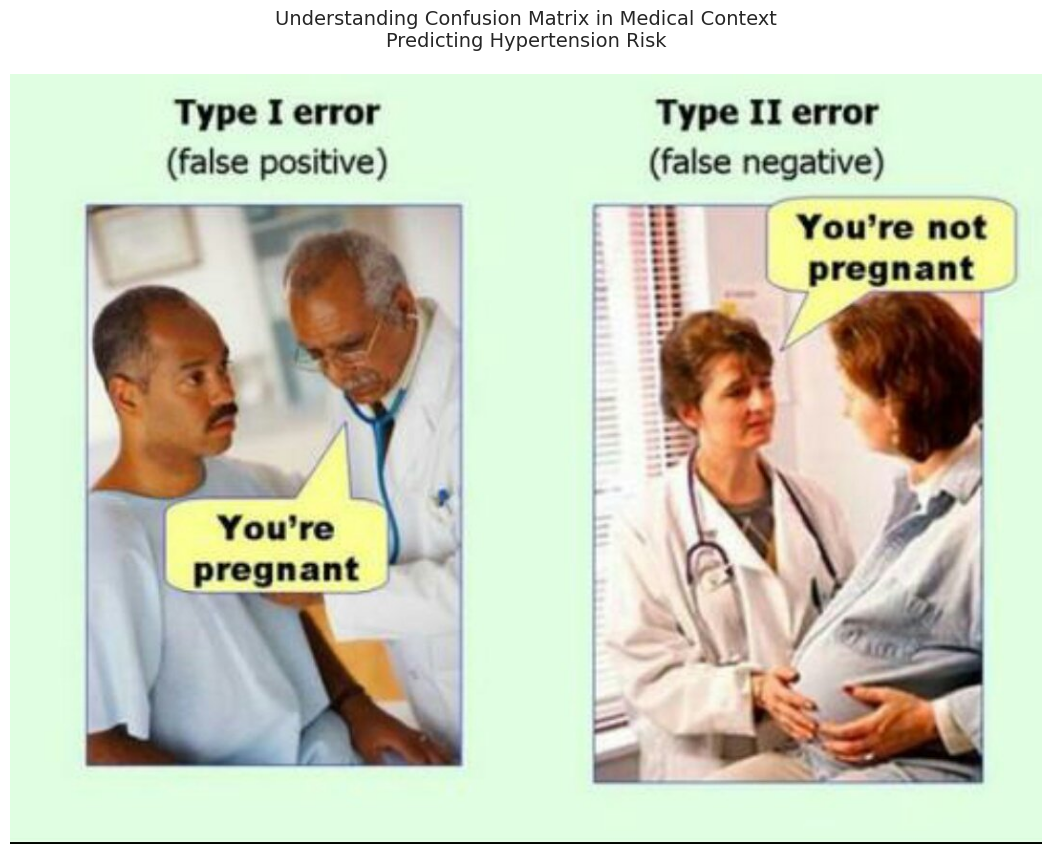


Confusion Matrix Interpretation:
--------------------------------------------------
True Negative (TN): Correctly identified patients WITHOUT hypertension
False Positive (FP): Incorrectly predicted hypertension when patient is healthy (Type I Error)
False Negative (FN): Failed to identify patients WITH hypertension (Type II Error)
True Positive (TP): Correctly identified patients WITH hypertension


In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load and display confusion matrix explanation image
try:
    plt.figure(figsize=(15, 10))
    img = mpimg.imread('/content/drive/MyDrive/Colab/hypertension_risk/images/fpfn_memes.jpg')
    plt.imshow(img)
    plt.axis('off')
    plt.title('Understanding Confusion Matrix in Medical Context\nPredicting Hypertension Risk', pad=20, size=14)
    plt.show()

    print("\nConfusion Matrix Interpretation:")
    print("-" * 50)
    print("True Negative (TN): Correctly identified patients WITHOUT hypertension")
    print("False Positive (FP): Incorrectly predicted hypertension when patient is healthy (Type I Error)")
    print("False Negative (FN): Failed to identify patients WITH hypertension (Type II Error)")
    print("True Positive (TP): Correctly identified patients WITH hypertension")

except Exception as e:
    print(f"Note: Could not load confusion matrix explanation image: {e}")
    print("Please ensure the image is saved in the correct location:")
    print("/content/drive/MyDrive/Colab/hypertension_risk/images/confusion_matrix_meme.jpg")

# 8. Model Evaluation

After training our model, it's crucial to evaluate its performance using various metrics and visualizations.

## 8.1 - Model Evaluation - Main Metrics


🔍 EVALUATING ON TRAINING SET

📊 EVALUATING TRAINING SET

📈 AUC-ROC PERFORMANCE

1. Final Model Performance:
   • Overall AUC: 0.8333

2. Cross-validation Performance:
   • Mean AUC: 0.8335 ± 0.0123
   • Individual Fold Scores:
     Fold 1: 0.8487
     Fold 2: 0.8349
     Fold 3: 0.8432
     Fold 4: 0.8265
     Fold 5: 0.8141

3. Performance Range:
   • Minimum AUC: 0.8141
   • Maximum AUC: 0.8487

4. Model Stability:
   • Variation (Std): 0.0123
   • Stability: Medium

📊 OTHER METRICS
• Accuracy: 0.7488
• Sensitivity: 0.7978
• Specificity: 0.7253
• Precision: 0.5813

🎯 CONFUSION MATRIX
• True Negatives (TN): 3602
• False Positives (FP): 1364
• False Negatives (FN): 480
• True Positives (TP): 1894

🔍 EVALUATING ON VALIDATION SET

📊 EVALUATING VALIDATION SET

📈 AUC-ROC PERFORMANCE

1. Final Model Performance:
   • Overall AUC: 0.8012

2. Cross-validation Performance:
   • Mean AUC: 0.8015 ± 0.0204
   • Individual Fold Scores:
     Fold 1: 0.7738
     Fold 2: 0.8065
     Fold 3: 0.8081
 

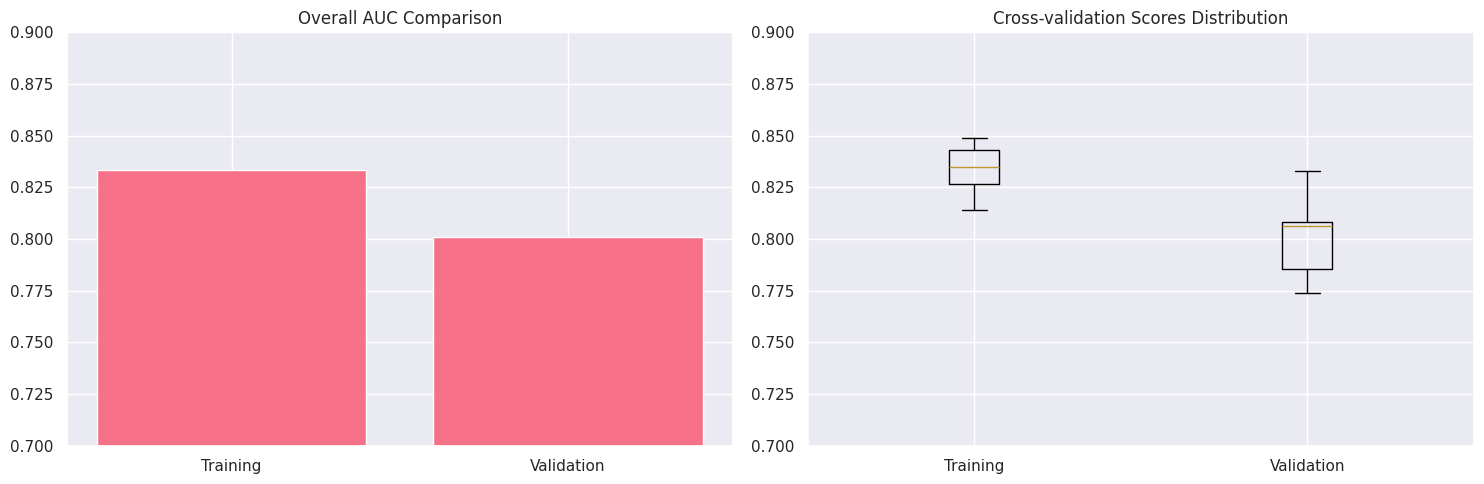


📊 PERFORMANCE SUMMARY

Training Set:
• Overall AUC: 0.8333
• CV AUC: 0.8335 ± 0.0123

Validation Set:
• Overall AUC: 0.8012
• CV AUC: 0.8015 ± 0.0204


In [10]:
def evaluate_model(model, X, y, dataset_name="", n_folds=5):
    """
    Evaluate model performance with clearer distinction between training and evaluation metrics
    """
    print(f"\n{'='*50}")
    print(f"📊 EVALUATING {dataset_name.upper()} SET")
    print(f"{'='*50}")

    # Calculate metrics as before
    y_pred_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)

    # Overall AUC
    overall_auc = roc_auc_score(y, y_pred_proba)

    # Cross-validation scores
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, val_idx in kf.split(X):
        X_fold = X[val_idx]
        y_fold = y.iloc[val_idx]
        fold_pred_proba = model.predict_proba(X_fold)[:, 1]
        cv_scores.append(roc_auc_score(y_fold, fold_pred_proba))

    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)

    print("\n📈 AUC-ROC PERFORMANCE")
    print("="*30)
    print("\n1. Final Model Performance:")
    print(f"   • Overall AUC: {overall_auc:.4f}")

    print("\n2. Cross-validation Performance:")
    print(f"   • Mean AUC: {cv_mean:.4f} ± {cv_std:.4f}")
    print("   • Individual Fold Scores:")
    for i, score in enumerate(cv_scores, 1):
        print(f"     Fold {i}: {score:.4f}")

    print("\n3. Performance Range:")
    print(f"   • Minimum AUC: {min(cv_scores):.4f}")
    print(f"   • Maximum AUC: {max(cv_scores):.4f}")

    print("\n4. Model Stability:")
    stability = "High" if cv_std < 0.01 else "Medium" if cv_std < 0.02 else "Low"
    print(f"   • Variation (Std): {cv_std:.4f}")
    print(f"   • Stability: {stability}")

    # Calculate other metrics
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    print("\n📊 OTHER METRICS")
    print("="*30)
    print(f"• Accuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")
    print(f"• Sensitivity: {tp / (tp + fn):.4f}")
    print(f"• Specificity: {tn / (tn + fp):.4f}")
    print(f"• Precision: {tp / (tp + fp):.4f}")

    print("\n🎯 CONFUSION MATRIX")
    print("="*30)
    print(f"• True Negatives (TN): {tn}")
    print(f"• False Positives (FP): {fp}")
    print(f"• False Negatives (FN): {fn}")
    print(f"• True Positives (TP): {tp}")

    return {
        'overall_auc': overall_auc,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'cv_scores': cv_scores,
        'confusion_matrix': [tn, fp, fn, tp]
    }

# 1. For Training Set Evaluation
print("\n🔍 EVALUATING ON TRAINING SET")
train_results = evaluate_model(
    model=model,
    X=X_train_processed,        # Preprocessed training features
    y=y_train,                  # Training target variable
    dataset_name="Training",    # Name for the evaluation
    n_folds=5                   # Number of cross-validation folds
)

# 2. For Validation Set Evaluation
print("\n🔍 EVALUATING ON VALIDATION SET")
val_results = evaluate_model(
    model=model,
    X=X_val_processed,          # Preprocessed validation features
    y=y_val,                    # Validation target variable
    dataset_name="Validation",  # Name for the evaluation
    n_folds=5                   # Number of cross-validation folds
)

# 3. Plot comparison of results
def plot_performance_comparison(train_results, val_results):
    """
    Plot comparison of training and validation performance
    """
    metrics = ['overall_auc', 'cv_mean']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot 1: Overall AUC Comparison
    ax1.bar(['Training', 'Validation'],
            [train_results['overall_auc'], val_results['overall_auc']])
    ax1.set_title('Overall AUC Comparison')
    ax1.set_ylim(0.7, 0.9)  # Adjust range as needed

    # Plot 2: Cross-validation Scores Distribution
    ax2.boxplot([train_results['cv_scores'], val_results['cv_scores']],
                labels=['Training', 'Validation'])
    ax2.set_title('Cross-validation Scores Distribution')
    ax2.set_ylim(0.7, 0.9)  # Adjust range as needed

    plt.tight_layout()
    plt.show()

# Generate performance comparison plot
plot_performance_comparison(train_results, val_results)

# 4. Print summary comparison
print("\n📊 PERFORMANCE SUMMARY")
print("="*50)
print("\nTraining Set:")
print(f"• Overall AUC: {train_results['overall_auc']:.4f}")
print(f"• CV AUC: {train_results['cv_mean']:.4f} ± {train_results['cv_std']:.4f}")
print("\nValidation Set:")
print(f"• Overall AUC: {val_results['overall_auc']:.4f}")
print(f"• CV AUC: {val_results['cv_mean']:.4f} ± {val_results['cv_std']:.4f}")

## 8.2 - ROC Curve Visualization

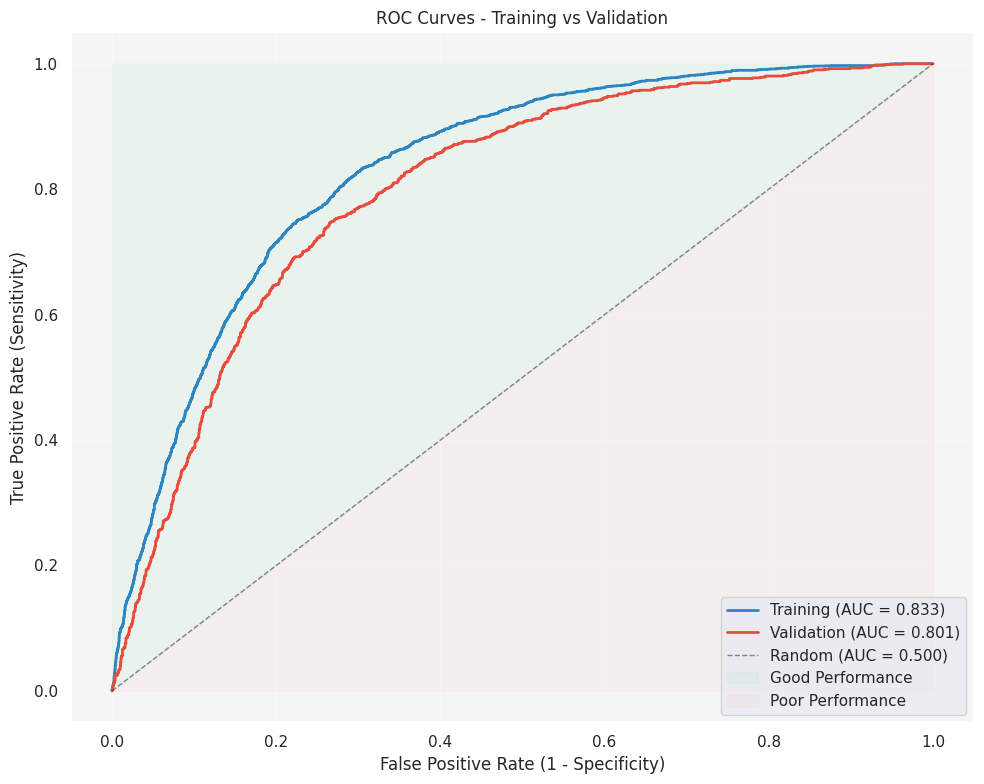

In [11]:
def plot_roc_curve(train_data, val_data):
    """
    Create a simple ROC curve visualization comparing training and validation performance.

    Parameters:
    -----------
    train_data : dict
        Dictionary containing 'y_true' and 'y_pred_proba' for training set
    val_data : dict
        Dictionary containing 'y_true' and 'y_pred_proba' for validation set
    """
    # Create figure
    plt.figure(figsize=(10, 8))

    # Calculate ROC curves
    # Training set ROC
    fpr_train, tpr_train, _ = roc_curve(train_data['y_true'],
                                       train_data['y_pred_proba'])
    train_auc = roc_auc_score(train_data['y_true'],
                             train_data['y_pred_proba'])

    # Validation set ROC
    fpr_val, tpr_val, _ = roc_curve(val_data['y_true'],
                                   val_data['y_pred_proba'])
    val_auc = roc_auc_score(val_data['y_true'],
                           val_data['y_pred_proba'])

    # Plot curves
    plt.plot(fpr_train, tpr_train, '#2E86C1',
             label=f'Training (AUC = {train_auc:.3f})',
             linewidth=2)
    plt.plot(fpr_val, tpr_val, '#E74C3C',
             label=f'Validation (AUC = {val_auc:.3f})',
             linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--',
             label='Random (AUC = 0.500)',
             linewidth=1, alpha=0.5)

    # Add performance zones
    plt.fill_between([0, 1], [0, 1], [1, 1], alpha=0.1,
                     color='#82E0AA', label='Good Performance')
    plt.fill_between([0, 1], [0, 1], [0, 0], alpha=0.1,
                     color='#F5B7B1', label='Poor Performance')

    # Customize plot
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curves - Training vs Validation')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

    # Set background colors
    plt.gca().set_facecolor('whitesmoke')
    plt.gcf().patch.set_facecolor('white')

    plt.tight_layout()
    plt.show()

    return {
        'train_auc': train_auc,
        'val_auc': val_auc
    }

# Usage
# Prepare data
train_data = {
    'y_true': y_train,
    'y_pred_proba': model.predict_proba(X_train_processed)[:, 1]
}

val_data = {
    'y_true': y_val,
    'y_pred_proba': model.predict_proba(X_val_processed)[:, 1]
}

# Create visualization
results = plot_roc_curve(train_data, val_data)

## 8.3 - Sensitivity-Specificity Tradeoff

In [12]:
def analyze_threshold(train_data, val_data):
    """
    Create interactive threshold analysis for both training and validation sets.

    Parameters:
    -----------
    train_data : dict
        Dictionary containing 'y_true' and 'y_pred_proba' for training set
    val_data : dict
        Dictionary containing 'y_true' and 'y_pred_proba' for validation set
    """
    print("\n📉 INTERACTIVE THRESHOLD ANALYSIS")
    print("="*50)
    print("""
Instructions:
• Use the slider to adjust the classification threshold
• Watch how different metrics change
• Lower threshold: More sensitive, but more false alarms
• Higher threshold: More specific, but might miss cases
    """)

    def plot_threshold_analysis(threshold):
        """Plot confusion matrix and metrics for a given threshold"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        fig.patch.set_facecolor('white')

        # Plot for training data
        y_true_train = train_data['y_true']
        y_pred_train = (train_data['y_pred_proba'] >= threshold).astype(int)
        cm_train = confusion_matrix(y_true_train, y_pred_train)
        tn_train, fp_train, fn_train, tp_train = cm_train.ravel()

        # Plot for validation data
        y_true_val = val_data['y_true']
        y_pred_val = (val_data['y_pred_proba'] >= threshold).astype(int)
        cm_val = confusion_matrix(y_true_val, y_pred_val)
        tn_val, fp_val, fn_val, tp_val = cm_val.ravel()

        # Calculate metrics
        def calculate_metrics(tn, fp, fn, tp):
            sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
            precision = tp / (tp + fp) if (tp + fp) != 0 else 0
            accuracy = (tp + tn) / (tp + tn + fp + fn)
            return sensitivity, specificity, precision, accuracy

        train_metrics = calculate_metrics(tn_train, fp_train, fn_train, tp_train)
        val_metrics = calculate_metrics(tn_val, fp_val, fn_val, tp_val)

        # Plot 1: Confusion Matrices
        ax1.set_title(f'Confusion Matrices (Threshold = {threshold:.2f})')

        # Training matrix on left
        ax1.text(0.25, 0.8, 'Training Set', horizontalalignment='center', transform=ax1.transAxes)
        ax1.text(0.25, 0.7, f'TN: {tn_train}', horizontalalignment='center', transform=ax1.transAxes)
        ax1.text(0.25, 0.6, f'FP: {fp_train}', horizontalalignment='center', transform=ax1.transAxes)
        ax1.text(0.25, 0.5, f'FN: {fn_train}', horizontalalignment='center', transform=ax1.transAxes)
        ax1.text(0.25, 0.4, f'TP: {tp_train}', horizontalalignment='center', transform=ax1.transAxes)

        # Validation matrix on right
        ax1.text(0.75, 0.8, 'Validation Set', horizontalalignment='center', transform=ax1.transAxes)
        ax1.text(0.75, 0.7, f'TN: {tn_val}', horizontalalignment='center', transform=ax1.transAxes)
        ax1.text(0.75, 0.6, f'FP: {fp_val}', horizontalalignment='center', transform=ax1.transAxes)
        ax1.text(0.75, 0.5, f'FN: {fn_val}', horizontalalignment='center', transform=ax1.transAxes)
        ax1.text(0.75, 0.4, f'TP: {tp_val}', horizontalalignment='center', transform=ax1.transAxes)

        ax1.axis('off')

        # Plot 2: Metrics
        metrics_names = ['Sensitivity', 'Specificity', 'Precision', 'Accuracy']
        x = np.arange(len(metrics_names))
        width = 0.35

        ax2.bar(x - width/2, train_metrics, width, label='Training', color='#2E86C1', alpha=0.7)
        ax2.bar(x + width/2, val_metrics, width, label='Validation', color='#E74C3C', alpha=0.7)

        ax2.set_ylabel('Score')
        ax2.set_title('Metrics Comparison')
        ax2.set_xticks(x)
        ax2.set_xticklabels(metrics_names, rotation=45)
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print detailed metrics
        print("\n📊 Detailed Metrics:")
        print(f"\nTraining Set (threshold = {threshold:.2f}):")
        print(f"• Sensitivity: {train_metrics[0]:.4f}")
        print(f"• Specificity: {train_metrics[1]:.4f}")
        print(f"• Precision: {train_metrics[2]:.4f}")
        print(f"• Accuracy: {train_metrics[3]:.4f}")

        print(f"\nValidation Set (threshold = {threshold:.2f}):")
        print(f"• Sensitivity: {val_metrics[0]:.4f}")
        print(f"• Specificity: {val_metrics[1]:.4f}")
        print(f"• Precision: {val_metrics[2]:.4f}")
        print(f"• Accuracy: {val_metrics[3]:.4f}")

    # Create interactive slider
    interact(
        plot_threshold_analysis,
        threshold=FloatSlider(
            value=0.5,
            min=0.1,
            max=0.9,
            step=0.05,
            description='Threshold:',
            style={'description_width': 'initial'}
        )
    )

# Usage
# Prepare data
train_data = {
    'y_true': y_train,
    'y_pred_proba': model.predict_proba(X_train_processed)[:, 1]
}

val_data = {
    'y_true': y_val,
    'y_pred_proba': model.predict_proba(X_val_processed)[:, 1]
}

# Create interactive analysis
analyze_threshold(train_data, val_data)


📉 INTERACTIVE THRESHOLD ANALYSIS

Instructions:
• Use the slider to adjust the classification threshold
• Watch how different metrics change
• Lower threshold: More sensitive, but more false alarms
• Higher threshold: More specific, but might miss cases
    


interactive(children=(FloatSlider(value=0.5, description='Threshold:', max=0.9, min=0.1, step=0.05, style=Slid…

# 9. Feature Importance Analysis

Understanding which features contribute most to the model's predictions helps in:
- Model interpretation
- Feature selection
- Clinical insights


🔍 Analyzing feature importance...

📊 FEATURE IMPORTANCE ANALYSIS

🔍 Calculating SHAP values...


/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')



📈 Feature Importance Summary:
--------------------------------------------------

Feature Importance Ranking:

familly_history_of_hypertension:
• Relative Importance: 15.05%
• Impact Score: 0.3986

salt_consumption:
• Relative Importance: 14.38%
• Impact Score: 0.3808

exercise_frequency:
• Relative Importance: 13.98%
• Impact Score: 0.3703

belly_circumference_cm:
• Relative Importance: 11.88%
• Impact Score: 0.3147

sugar_consumption:
• Relative Importance: 11.30%
• Impact Score: 0.2992

smoking_status:
• Relative Importance: 10.43%
• Impact Score: 0.2763

weight_kg:
• Relative Importance: 6.96%
• Impact Score: 0.1843

height_cm:
• Relative Importance: 5.98%
• Impact Score: 0.1584

age:
• Relative Importance: 5.41%
• Impact Score: 0.1432

gender:
• Relative Importance: 4.63%
• Impact Score: 0.1226


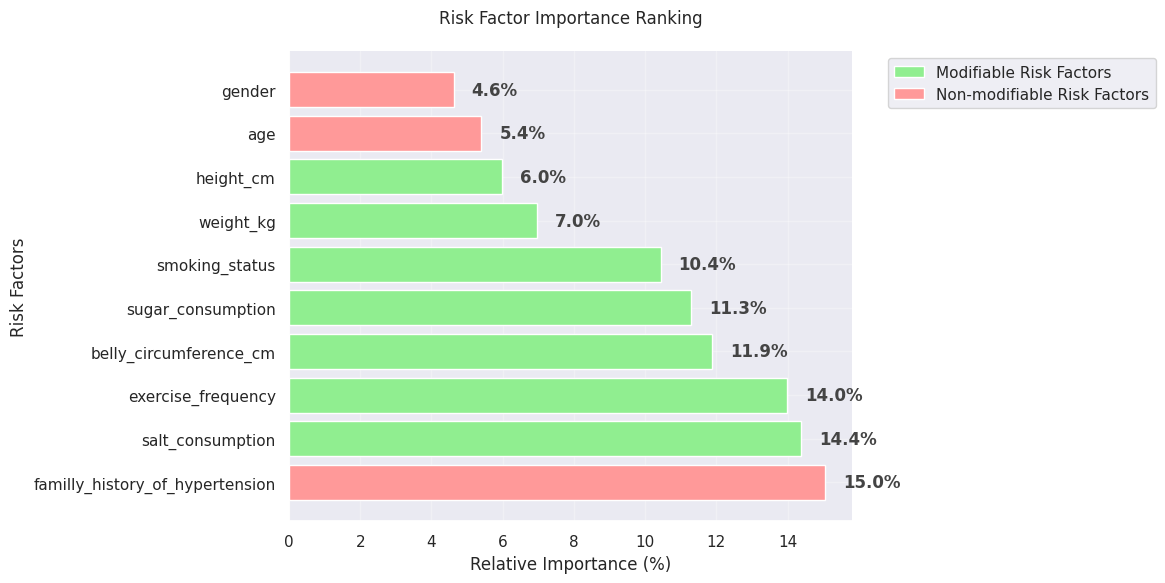

In [13]:
def analyze_feature_importance(model, X_processed, y, feature_names, dataset_name=""):
    """
    Analyze and visualize feature importance using SHAP values with softer colors.
    """
    print(f"\n{'='*50}")
    print("📊 FEATURE IMPORTANCE ANALYSIS")
    print(f"{'='*50}")

    # Convert processed features back to DataFrame
    X_df = pd.DataFrame(X_processed, columns=feature_names)

    try:
        # Calculate SHAP values
        print("\n🔍 Calculating SHAP values...")
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_df)

        # If shap_values is a list (for binary classification), take the second element
        if isinstance(shap_values, list):
            shap_values = shap_values[1]

        # Calculate feature importance
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': np.abs(shap_values).mean(axis=0)
        })

        # Group encoded features back to original features
        original_features = {
            'salt_consumption': [col for col in feature_names if col.startswith('salt_consumption')],
            'familly_history_of_hypertension': [col for col in feature_names if col.startswith('family_history')],
            'age': ['age'],
            'exercise_frequency': [col for col in feature_names if col.startswith('exercise_frequency')],
            'belly_circumference_cm': ['belly_circumference_cm'],
            'gender': [col for col in feature_names if col.startswith('gender')],
            'smoking_status': [col for col in feature_names if col.startswith('smoking_status')],
            'sugar_consumption': [col for col in feature_names if col.startswith('sugar_consumption')],
            'weight_kg': ['weight_kg'],
            'height_cm': ['height_cm']
        }

        # Calculate grouped importance
        grouped_importance = []
        for original_feature, encoded_features in original_features.items():
            total_importance = feature_importance[
                feature_importance['Feature'].isin(encoded_features)
            ]['Importance'].sum()

            grouped_importance.append({
                'Feature': original_feature,
                'Importance': total_importance
            })

        # Convert to DataFrame and sort
        grouped_importance_df = pd.DataFrame(grouped_importance)
        grouped_importance_df = grouped_importance_df.sort_values('Importance', ascending=False)

        # Calculate relative importance (percentage)
        total_importance = grouped_importance_df['Importance'].sum()
        grouped_importance_df['Importance_Percentage'] = (
            grouped_importance_df['Importance'] / total_importance * 100
        )

        # Print summary
        print("\n📈 Feature Importance Summary:")
        print("-" * 50)
        print("\nFeature Importance Ranking:")
        for idx, row in grouped_importance_df.iterrows():
            print(f"\n{row['Feature']}:")
            print(f"• Relative Importance: {row['Importance_Percentage']:.2f}%")
            print(f"• Impact Score: {row['Importance']:.4f}")

        # Create importance ranking visualization
        plt.figure(figsize=(12, 6))

        # Define softer colors
        soft_red = '#FF9999'    # Soft red for non-modifiable factors
        soft_green = '#90EE90'  # Soft green for modifiable factors

        # Create color mapping for modifiable vs non-modifiable factors
        non_modifiable = ['age', 'familly_history_of_hypertension', 'gender']
        colors = [soft_red if feature in non_modifiable else soft_green
                 for feature in grouped_importance_df['Feature']]

        # Plot bars
        bars = plt.barh(
            grouped_importance_df['Feature'],
            grouped_importance_df['Importance_Percentage'],
            color=colors
        )

        # Add percentage labels with improved visibility
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
                    f'{width:.1f}%',
                    va='center', ha='left', fontweight='bold',
                    color='#444444')  # Darker gray for better readability

        # Customize plot
        plt.title('Risk Factor Importance Ranking', fontsize=12, pad=20)
        plt.xlabel('Relative Importance (%)')
        plt.ylabel('Risk Factors')

        # Add legend with softer colors
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor=soft_green, label='Modifiable Risk Factors'),
            Patch(facecolor=soft_red, label='Non-modifiable Risk Factors')
        ]
        plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

        # Style improvements
        plt.grid(True, alpha=0.3)  # Add subtle grid
        plt.gca().spines['top'].set_visible(False)  # Remove top border
        plt.gca().spines['right'].set_visible(False)  # Remove right border

        # Adjust layout and display
        plt.tight_layout()
        plt.show()

        return grouped_importance_df, shap_values

    except Exception as e:
        print(f"⚠️ Error in feature importance analysis: {e}")
        raise

# Usage
print("\n🔍 Analyzing feature importance...")
feature_importance, shap_values = analyze_feature_importance(
    model,
    X_train_processed,
    y_train,
    feature_names,
    "Training"
)

# 9.1 Selection Feature


📚 FEATURE SELECTION ANALYSIS


📌 Top 3 Features
--------------------------------------------------
Features used:
1. family_history_1.0
2. salt_consumption_low
3. exercise_frequency_low

AUC Score: 0.701


📌 Top 5 Features
--------------------------------------------------
Features used:
1. family_history_1.0
2. salt_consumption_low
3. exercise_frequency_low
4. belly_circumference_cm
5. sugar_consumption_low

AUC Score: 0.764


📌 Top 7 Features
--------------------------------------------------
Features used:
1. family_history_1.0
2. salt_consumption_low
3. exercise_frequency_low
4. belly_circumference_cm
5. sugar_consumption_low
6. smoking_status_quit
7. smoking_status_smoker

AUC Score: 0.779


📌 Top 9 Features
--------------------------------------------------
Features used:
1. family_history_1.0
2. salt_consumption_low
3. exercise_frequency_low
4. belly_circumference_cm
5. sugar_consumption_low
6. smoking_status_quit
7. smoking_status_smoker
8. weight_kg
9. height_cm

AUC Score: 0

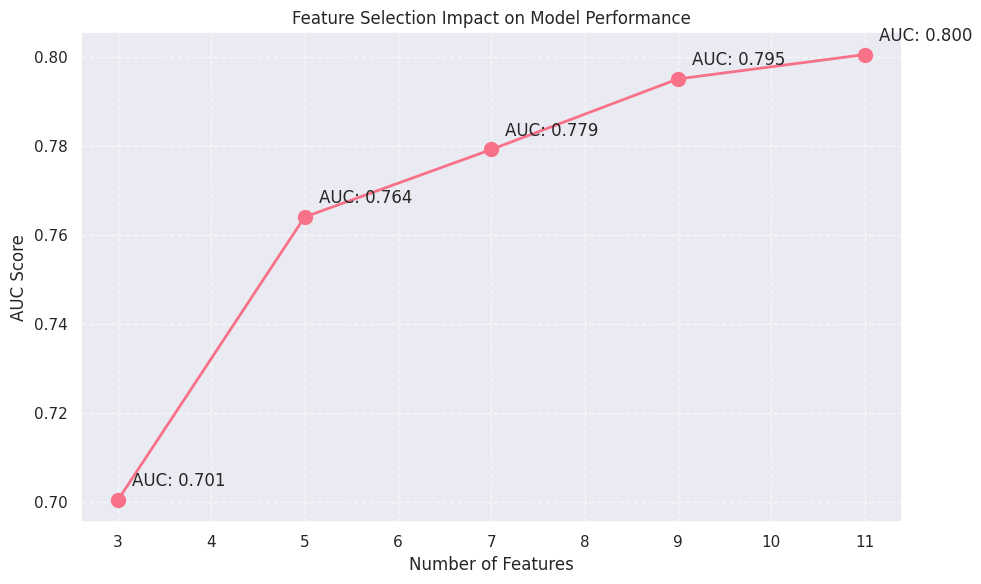

In [14]:
def analyze_feature_combinations(model, X_train, X_val, y_train, y_val, feature_names):
    """
    Analyze model performance with different feature combinations based on importance ranking.
    """
    print("\n📚 FEATURE SELECTION ANALYSIS")
    print("="*50)

    # Get all encoded feature names for each original feature
    family_features = [f for f in feature_names if f.startswith('family_history')]
    salt_features = [f for f in feature_names if f.startswith('salt_consumption')]
    exercise_features = [f for f in feature_names if f.startswith('exercise_frequency')]
    belly_features = ['belly_circumference_cm']
    sugar_features = [f for f in feature_names if f.startswith('sugar_consumption')]
    smoking_features = [f for f in feature_names if f.startswith('smoking_status')]
    weight_features = ['weight_kg']
    height_features = ['height_cm']
    age_features = ['age']
    gender_features = [f for f in feature_names if f.startswith('gender')]

    # Define ordered features based on actual importance analysis
    ordered_features = (
        family_features +           # 15.0%
        salt_features +            # 14.4%
        exercise_features +        # 14.0%
        belly_features +           # 11.9%
        sugar_features +           # 11.3%
        smoking_features +         # 10.4%
        weight_features +          # 7.0%
        height_features +          # 6.0%
        age_features +            # 5.4%
        gender_features           # 4.6%
    )

    # Define Feature Sets
    feature_sets = {
        'Top 3 Features': ordered_features[:3],  # Family, Salt, Exercise
        'Top 5 Features': ordered_features[:5],  # + Belly, Sugar
        'Top 7 Features': ordered_features[:7],  # + Smoking, Weight
        'Top 9 Features': ordered_features[:9],  # + Height, Age
        'All Features': ordered_features        # + Gender
    }

    results = []

    # Test Each Feature Set
    for set_name, selected_features in feature_sets.items():
        print(f"\n\n📌 {set_name}")
        print("-"*50)
        print("Features used:")
        for i, feature in enumerate(selected_features, 1):
            print(f"{i}. {feature}")

        try:
            # Create and train model
            model_params = model.get_params()
            model_subset = LGBMClassifier(**model_params)

            # Select features
            X_train_subset = pd.DataFrame(X_train, columns=feature_names)[selected_features]
            X_val_subset = pd.DataFrame(X_val, columns=feature_names)[selected_features]

            # Train model and get predictions
            model_subset.fit(X_train_subset, y_train)
            val_pred = model_subset.predict_proba(X_val_subset)[:, 1]

            # Calculate AUC
            val_auc = roc_auc_score(y_val, val_pred)
            print(f"\nAUC Score: {val_auc:.3f}")

            results.append({
                'Set_Name': set_name,
                'Num_Features': len(selected_features),
                'Features': selected_features,
                'AUC': val_auc
            })

        except Exception as e:
            print(f"⚠️ Error: {str(e)}")
            print("Selected features:", selected_features)

    # Create results DataFrame
    results_df = pd.DataFrame(results)

    # Print summary of results
    print("\n\n🎯 SUMMARY OF RESULTS")
    print("="*50)

    # Find best performing set
    best_set = results_df.loc[results_df['AUC'].idxmax()]

    # Print results in order of performance
    for _, row in results_df.sort_values('AUC', ascending=False).iterrows():
        print(f"\n• {row['Set_Name']}:")
        print(f"  - Number of features: {row['Num_Features']}")
        print(f"  - AUC Score: {row['AUC']:.3f}")
        if row['Set_Name'] == best_set['Set_Name']:
            print("  ⭐ BEST PERFORMING SET")

    # Visualize results
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['Num_Features'], results_df['AUC'],
             marker='o', linewidth=2, markersize=10)

    # Add labels to points
    for idx, row in results_df.iterrows():
        plt.annotate(f"AUC: {row['AUC']:.3f}",
                    (row['Num_Features'], row['AUC']),
                    xytext=(10, 10), textcoords='offset points')

    plt.xlabel('Number of Features')
    plt.ylabel('AUC Score')
    plt.title('Feature Selection Impact on Model Performance')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return results_df

# Execute the analysis
results = analyze_feature_combinations(
    model=model,
    X_train=X_train_processed,
    X_val=X_val_processed,
    y_train=y_train,
    y_val=y_val,
    feature_names=feature_names
)

In [15]:
# Define selected features based on importance
selected_features = [
    'family_history',                   # 15.0%
    'salt_consumption',                 # 14.4%
    'exercise_frequency',               # 14.0%
    'belly_circumference_cm',           # 11.9%
    'sugar_consumption',                # 11.3%
    'smoking_status',                   # 10.4%
    'weight_kg',                        # 7.0%
    'height_cm',                        # 6.0%
]

def create_preprocessing_pipeline(categorical_features: List[str],
                                numeric_features: List[str]) -> Pipeline:
    """
    Create a preprocessing pipeline for both categorical and numeric features.
    """
    # Numeric features pipeline
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Categorical features pipeline
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False))
    ])

    # Combine transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    return preprocessor

def prepare_data(df: pd.DataFrame) -> Tuple:
    """
    Prepare and preprocess the data for modeling
    """
    print("="*50)
    print("🔄 DATA PREPARATION")
    print("="*50)

    # Separate features into categorical and numeric
    categorical_features = [
        'family_history',
        'salt_consumption',
        'exercise_frequency',
        'sugar_consumption',
        'smoking_status'
    ]

    numeric_features = [
        'belly_circumference_cm',
        'weight_kg',
        'height_cm'
    ]

    # Create preprocessing pipeline
    preprocessor = create_preprocessing_pipeline(categorical_features, numeric_features)

    # Split data
    X = df[selected_features]
    y = df['label_hypertension']

    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=0.3,
        random_state=42,
        stratify=y
    )

    # Fit preprocessor and transform data
    X_train_processed = preprocessor.fit_transform(X_train)
    X_val_processed = preprocessor.transform(X_val)

    # Get feature names after preprocessing
    numeric_features_out = numeric_features

    # Get categorical feature names after one-hot encoding
    cat_features_out = []
    for i, feature in enumerate(categorical_features):
        encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
        categories = encoder.categories_[i][1:]
        cat_features_out.extend([f"{feature}_{cat}" for cat in categories])

    # Combine all feature names
    feature_names = numeric_features_out + cat_features_out

    print(f"\nData splits:")
    print(f"Training set: {X_train_processed.shape}")
    print(f"Validation set: {X_val_processed.shape}")
    print("\nFeatures after preprocessing:")
    for f in feature_names:
        print(f"- {f}")

    return X_train_processed, X_val_processed, y_train, y_val, feature_names, preprocessor

def create_final_model(X_train, X_val, y_train, y_val, feature_names):
    """
    Creates and trains the final model using preprocessed features
    """
    print("="*50)
    print("🚀 FINAL MODEL WITH SELECTED FEATURES")
    print("="*50)

    # Calculate class weights
    n_negative = len(y_train[y_train == 0])
    n_positive = len(y_train[y_train == 1])
    scale_pos_weight = n_negative / n_positive

    print(f"\n📊 Class Balance:")
    print(f"Negative cases: {n_negative}")
    print(f"Positive cases: {n_positive}")
    print(f"Scale pos weight: {scale_pos_weight:.2f}")

    # Model parameters
    model_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'n_estimators': 1000,
        'learning_rate': 0.01,
        'num_leaves': 20,
        'max_depth': 4,
        'min_data_in_leaf': 20,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'lambda_l1': 0.1,
        'lambda_l2': 0.1,
        'scale_pos_weight': scale_pos_weight,
        'random_state': 42,
        'verbose': -1
    }

    print("\n⚙️ Model Configuration:")
    for param, value in model_params.items():
        print(f"{param}: {value}")

    # Cross-validation
    print("\n📊 Cross-validation Results:")
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores_train = []
    cv_scores_val = []
    best_score = 0
    best_model = None

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"\nTraining Fold {fold + 1}/5")
        X_fold_train = X_train[train_idx]
        y_fold_train = y_train.iloc[train_idx]
        X_fold_val = X_train[val_idx]
        y_fold_val = y_train.iloc[val_idx]

        try:
            # Create and train model
            model = LGBMClassifier(**model_params)
            model.fit(
                X_fold_train,
                y_fold_train,
                eval_set=[(X_fold_val, y_fold_val)],
                eval_metric=['auc', 'binary_logloss'],
                callbacks=[
                    early_stopping(stopping_rounds=50),
                    log_evaluation(period=100)
                ],
                feature_name=feature_names
            )

            # Calculate scores
            train_pred = model.predict_proba(X_fold_train)[:, 1]
            train_score = roc_auc_score(y_fold_train, train_pred)
            cv_scores_train.append(train_score)

            val_pred = model.predict_proba(X_fold_val)[:, 1]
            val_score = roc_auc_score(y_fold_val, val_pred)
            cv_scores_val.append(val_score)

            print(f"Fold {fold + 1} Training AUC-ROC: {train_score:.4f}")
            print(f"Fold {fold + 1} Validation AUC-ROC: {val_score:.4f}")

            # Save best model
            if val_score > best_score:
                best_score = val_score
                best_model = model

        except Exception as e:
            print(f"⚠️ Error in fold {fold + 1}: {str(e)}")
            continue

    # Print final cross-validation results
    if cv_scores_val:
        mean_train_auc = np.mean(cv_scores_train)
        std_train_auc = np.std(cv_scores_train)
        mean_val_auc = np.mean(cv_scores_val)
        std_val_auc = np.std(cv_scores_val)

        print("\n📊 Final Cross-Validation Results:")
        print("="*50)
        print(f"\nTraining AUC-ROC: {mean_train_auc:.4f} ± {std_train_auc:.4f}")
        print(f"Validation AUC-ROC: {mean_val_auc:.4f} ± {std_val_auc:.4f}")

        print("\n🔍 Model Performance Analysis:")
        train_val_gap = mean_train_auc - mean_val_auc
        print(f"Generalization gap: {train_val_gap:.4f}")
        if train_val_gap < 0.02:
            print("Excellent generalization to new data")
        elif train_val_gap < 0.05:
            print("Good generalization with minimal overfitting")
        else:
            print("Some overfitting detected")

    return best_model, selected_features, feature_names, preprocessor

# Process the data
X_train_processed, X_val_processed, y_train, y_val, feature_names, preprocessor = prepare_data(df_train_cleaned)

# Train the final model
final_model, original_features, encoded_features, preprocessor = create_final_model(  # Changed unpacking
    X_train=X_train_processed,
    X_val=X_val_processed,
    y_train=y_train,
    y_val=y_val,
    feature_names=feature_names
)

# Save the model and preprocessor with both original and encoded features
save_model((final_model, original_features, encoded_features, preprocessor))

🔄 DATA PREPARATION

Data splits:
Training set: (7340, 9)
Validation set: (3146, 9)

Features after preprocessing:
- belly_circumference_cm
- weight_kg
- height_cm
- family_history_1.0
- salt_consumption_low
- exercise_frequency_low
- sugar_consumption_low
- smoking_status_quit
- smoking_status_smoker
🚀 FINAL MODEL WITH SELECTED FEATURES

📊 Class Balance:
Negative cases: 4966
Positive cases: 2374
Scale pos weight: 2.09

⚙️ Model Configuration:
boosting_type: gbdt
objective: binary
n_estimators: 1000
learning_rate: 0.01
num_leaves: 20
max_depth: 4
min_data_in_leaf: 20
feature_fraction: 0.8
bagging_fraction: 0.8
bagging_freq: 1
lambda_l1: 0.1
lambda_l2: 0.1
scale_pos_weight: 2.091828138163437
random_state: 42
verbose: -1

📊 Cross-validation Results:

Training Fold 1/5
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.798752	valid_0's binary_logloss: 0.549558
[200]	valid_0's auc: 0.803679	valid_0's binary_logloss: 0.539561
[300]	valid_0's auc: 0.806607	val

# !UNPACK Model

In [16]:
def predict_hypertension_risk(
    model_path: str,
    input_data: Dict[str, Union[str, int, float]]
) -> Dict:
    """
    Predict hypertension risk using the saved model
    """
    print("🔄 Loading model and making prediction...")
    print("="*50)

    try:
        # Load the saved model components
        model, original_features, encoded_features, preprocessor = joblib.load(model_path)

        # Create DataFrame from input data
        new_data = pd.DataFrame([input_data])

        # Verify input data
        print("\n✅ Input Validation:")
        print("-"*50)

        # Check for missing required features
        missing_features = set(original_features) - set(new_data.columns)
        if missing_features:
            raise ValueError(f"Missing required features: {missing_features}")

        # Validate value ranges
        if not (50 <= new_data['belly_circumference_cm'].iloc[0] <= 220):
            print("⚠️ Warning: Belly circumference should be between 50-220 cm")

        if not (30 <= new_data['weight_kg'].iloc[0] <= 200):
            print("⚠️ Warning: Weight should be between 30-200 kg")

        if not (140 <= new_data['height_cm'].iloc[0] <= 220):
            print("⚠️ Warning: Height should be between 140-220 cm")

        # Preprocess the input data using original features
        X_processed = preprocessor.transform(new_data[original_features])

        # Make prediction
        prediction_prob = model.predict_proba(X_processed)[:, 1][0]
        prediction_class = 1 if prediction_prob >= 0.5 else 0

        # Define risk levels
        if prediction_prob < 0.2:
            risk_level = "Very Low"
            recommendation = "Maintain healthy lifestyle"
        elif prediction_prob < 0.4:
            risk_level = "Low"
            recommendation = "Continue good habits, regular check-ups"
        elif prediction_prob < 0.6:
            risk_level = "Moderate"
            recommendation = "Consider lifestyle changes, consult healthcare provider"
        elif prediction_prob < 0.8:
            risk_level = "High"
            recommendation = "Immediate lifestyle changes, regular medical monitoring"
        else:
            risk_level = "Very High"
            recommendation = "Urgent medical consultation recommended"

        # Prepare results
        results = {
            "probability": prediction_prob,
            "risk_level": risk_level,
            "prediction_class": prediction_class,
            "recommendation": recommendation,
            "input_data": input_data
        }

        # Print detailed results
        print("\n📊 Prediction Results:")
        print("-"*50)
        print(f"Risk Probability: {prediction_prob:.3f}")
        print(f"Risk Level: {risk_level} ({prediction_prob*100:.1f}%)")
        print(f"Classification: {'High Risk' if prediction_class == 1 else 'Low Risk'}")

        print("\n💡 Recommendation:")
        print("-"*50)
        print(recommendation)

        print("\n📋 Input Values:")
        print("-"*50)
        for key, value in input_data.items():
            print(f"{key}: {value}")

        return results

    except Exception as e:
        print(f"\n⚠️ Error during prediction: {str(e)}")
        return None

In [18]:
# Load model and make prediction
model_path = '/content/drive/MyDrive/Colab/hypertension_risk/model/hypertension_model_20241111_1508.joblib'

input_data = {
    'family_history': 0,                   # 0 or 1
    'salt_consumption': 'high',            # 'high' or 'low'
    'exercise_frequency': 'low',           # 'high' or 'low'
    'belly_circumference_cm': 99,          # 50-220 cm
    'sugar_consumption': 'high',           # 'high' or 'low'
    'smoking_status': 'never',             # 'never', 'quit', or 'smoker'
    'weight_kg': 200.0,                     # 60-200 kg
    'height_cm': 165.0                     # 100-220 cm
}

results = predict_hypertension_risk(model_path, input_data)

🔄 Loading model and making prediction...

✅ Input Validation:
--------------------------------------------------

📊 Prediction Results:
--------------------------------------------------
Risk Probability: 0.601
Risk Level: High (60.1%)
Classification: High Risk

💡 Recommendation:
--------------------------------------------------
Immediate lifestyle changes, regular medical monitoring

📋 Input Values:
--------------------------------------------------
family_history: 0
salt_consumption: high
exercise_frequency: low
belly_circumference_cm: 99
sugar_consumption: high
smoking_status: never
weight_kg: 200.0
height_cm: 165.0


# 10. Evaluating Model Performance on TEST DATA

In [19]:
df_test_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4417 entries, 0 to 5999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      4417 non-null   int64  
 1   age                     4417 non-null   int64  
 2   gender                  4328 non-null   object 
 3   height_cm               4417 non-null   float64
 4   weight_kg               4417 non-null   float64
 5   belly_circumference_cm  4417 non-null   float64
 6   smoking_status          4287 non-null   object 
 7   exercise_frequency      4122 non-null   object 
 8   salt_consumption        4199 non-null   object 
 9   sugar_consumption       4165 non-null   object 
 10  self_emotional          422 non-null    float64
 11  family_history          4284 non-null   float64
 12  label_hypertension      4417 non-null   int64  
 13  input_time              4417 non-null   object 
dtypes: float64(5), int64(3), object(6)
memory usa

In [24]:
def plot_model_visualizations(y_test, y_pred, y_pred_proba, conf_matrix, risk_distribution):
    """
    Create and display model performance visualizations with proper spacing
    """
    # Set figure style for better visualizations
    plt.style.use('default')  # Using default style instead of seaborn

    # 1. Confusion Matrix Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Hypertension', 'Hypertension'],
                yticklabels=['No Hypertension', 'Hypertension'])
    plt.title('Confusion Matrix', pad=20)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    print("\n") # Add spacing between plots

    # 2. Distribution of Predictions
    plt.figure(figsize=(12, 6))
    for label in [0, 1]:
        mask = y_test == label
        plt.hist(y_pred_proba[mask], bins=20, alpha=0.5,
                label=f"True {'Hypertension' if label else 'No Hypertension'}")
    plt.title('Distribution of Predicted Probabilities', pad=20)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\n") # Add spacing between plots

    # 3. Risk Level Distribution
    plt.figure(figsize=(12, 6))
    ax = risk_distribution.plot(kind='bar')
    plt.title('Distribution of Risk Levels', pad=20)
    plt.xlabel('Risk Level')
    plt.ylabel('Count')

    # Add value labels on top of each bar
    for i, v in enumerate(risk_distribution):
        ax.text(i, v, str(v), ha='center', va='bottom')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def preview_and_save_predictions(df_predictions: pd.DataFrame, output_path: str = None) -> None:
    """
    Preview and save predictions to CSV file
    """
    # Select important columns for preview
    preview_columns = [
        'label_hypertension',
        'predicted_label',
        'predicted_probability',
        'risk_level',
        'age',
        'gender',
        'family_history',
        'salt_consumption',
        'exercise_frequency',
        'belly_circumference_cm',
        'sugar_consumption',
        'smoking_status',
        'weight_kg',
        'height_cm'
    ]

    # Ensure all columns exist in DataFrame
    preview_columns = [col for col in preview_columns if col in df_predictions.columns]

    print("\n📋 Preview of Predictions (Top 10 highest probability cases):")
    print("="*100)
    display(df_predictions[preview_columns].head(10))

    if output_path:
        try:
            df_predictions.to_csv(output_path, index=False)
            print("\n✅ Results saved successfully!")
            print(f"Predictions saved to: {output_path}")
        except Exception as e:
            print(f"\n⚠️ Error saving results: {str(e)}")

def evaluate_model_on_test_data(
    model_path: str,
    df_test: pd.DataFrame
) -> Tuple[pd.DataFrame, dict]:
    """
    Evaluate the model performance on test data
    """
    print("="*50)
    print("🔄 PREDICTIONS ON TEST DATA")
    print("="*50)

    try:
        # Load the model
        model, original_features, encoded_features, preprocessor = joblib.load(model_path)

        # Get features from test data
        X_test = df_test[original_features]
        y_test = df_test['label_hypertension']

        # Preprocess test data
        X_test_processed = preprocessor.transform(X_test)

        # Make predictions
        y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
        y_pred = (y_pred_proba >= 0.5).astype(int)

        # Create DataFrame with predictions
        df_predictions = df_test.copy()
        df_predictions['predicted_probability'] = y_pred_proba
        df_predictions['predicted_label'] = y_pred

        # Add risk level
        def get_risk_level(prob):
            if prob < 0.2: return "Very Low"
            elif prob < 0.4: return "Low"
            elif prob < 0.6: return "Moderate"
            elif prob < 0.8: return "High"
            else: return "Very High"

        df_predictions['risk_level'] = df_predictions['predicted_probability'].apply(get_risk_level)

        # Sort by predicted probability (highest to lowest)
        df_predictions = df_predictions.sort_values('predicted_probability', ascending=False)

        print("\n✅ Predictions completed!")
        print(f"Number of test samples: {len(X_test)}")

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = conf_matrix.ravel()

        # Calculate detailed metrics
        metrics = {
            'AUC': roc_auc_score(y_test, y_pred_proba),
            'Sensitivity': tp / (tp + fn),  # True Positive Rate
            'Specificity': tn / (tn + fp),  # True Negative Rate
            'Accuracy': (tp + tn) / (tp + tn + fp + fn),
            'Precision': tp / (tp + fp),
            'NPV': tn / (tn + fn),  # Negative Predictive Value
            'F1': 2 * (tp / (tp + fp) * tp / (tp + fn)) / (tp / (tp + fp) + tp / (tp + fn))
        }

        print("\n📊 MODEL PERFORMANCE METRICS")
        print("="*50)

        # Print metrics
        print("\nDetailed Performance Metrics:")
        print("-"*30)
        for metric, value in metrics.items():
            print(f"{metric}: {value:.3f}")

        # Print confusion matrix
        print("\nConfusion Matrix:")
        print("-"*30)
        print(f"True Negatives: {tn}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"True Positives: {tp}")

        # Print classification report
        print("\nDetailed Classification Report:")
        print("-"*30)
        print(classification_report(y_test, y_pred))

        print("\n📈 VISUALIZATION OF RESULTS")
        print("="*50)

        # Create visualizations
        plot_model_visualizations(
            y_test=y_test,
            y_pred=y_pred,
            y_pred_proba=y_pred_proba,
            conf_matrix=conf_matrix,
            risk_distribution=df_predictions['risk_level'].value_counts()
        )

        return df_predictions, metrics

    except Exception as e:
        print(f"\n⚠️ Error during evaluation: {str(e)}")
        return None, None

🔄 PREDICTIONS ON TEST DATA

✅ Predictions completed!
Number of test samples: 4417

📊 MODEL PERFORMANCE METRICS

Detailed Performance Metrics:
------------------------------
AUC: 0.797
Sensitivity: 0.760
Specificity: 0.703
Accuracy: 0.722
Precision: 0.551
NPV: 0.860
F1: 0.639

Confusion Matrix:
------------------------------
True Negatives: 2099
False Positives: 887
False Negatives: 343
True Positives: 1088

Detailed Classification Report:
------------------------------
              precision    recall  f1-score   support

           0       0.86      0.70      0.77      2986
           1       0.55      0.76      0.64      1431

    accuracy                           0.72      4417
   macro avg       0.71      0.73      0.71      4417
weighted avg       0.76      0.72      0.73      4417


📈 VISUALIZATION OF RESULTS


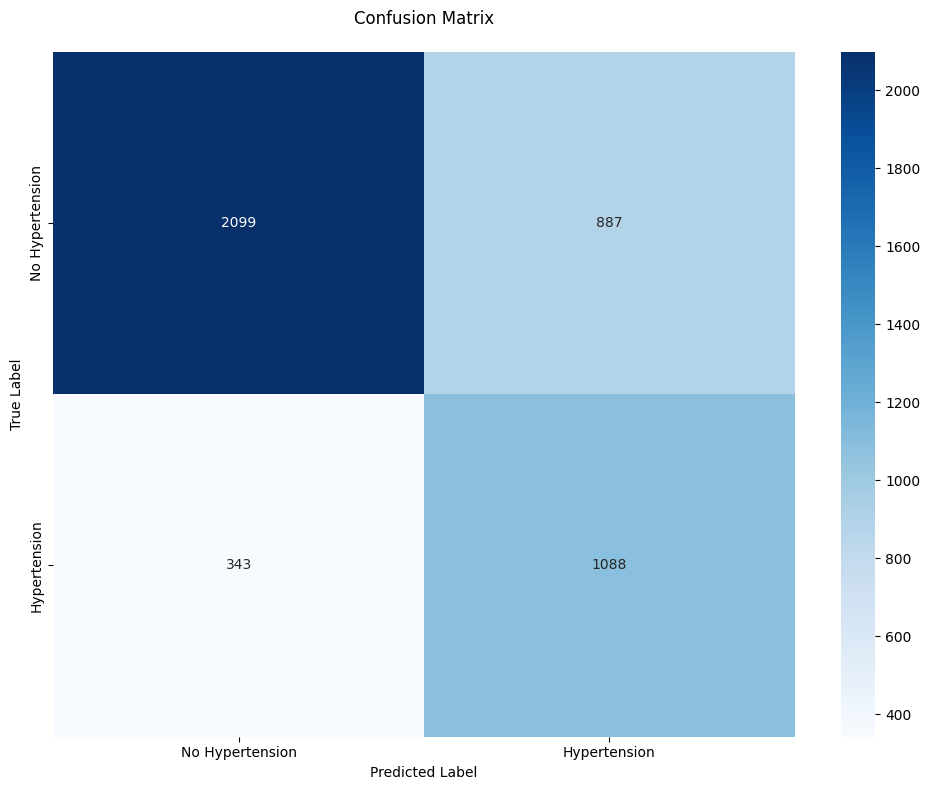

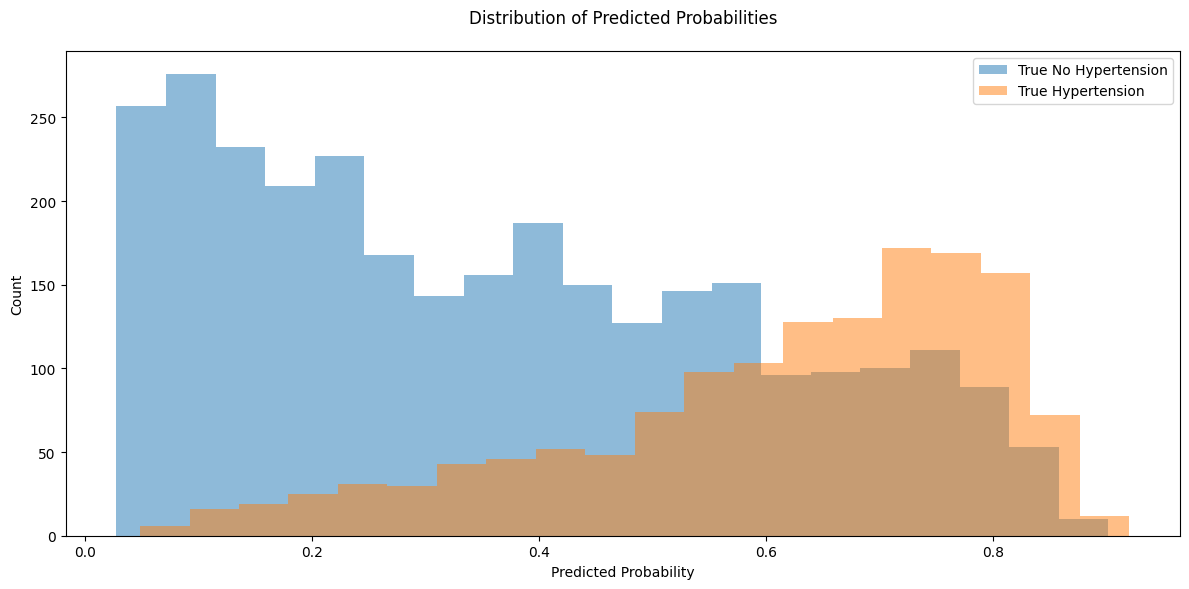

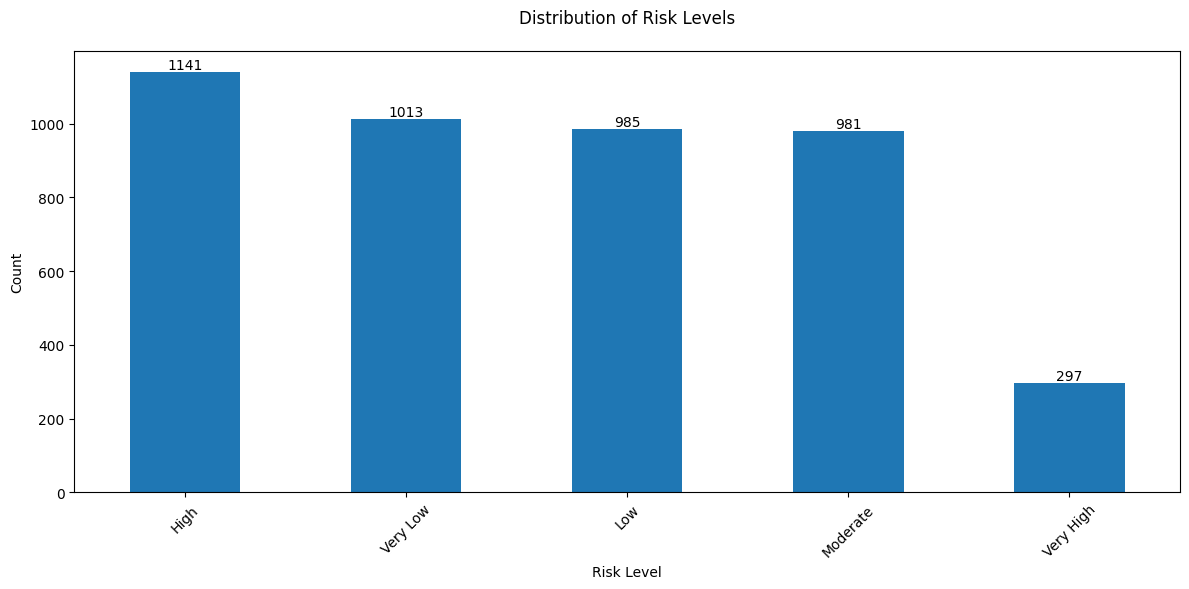

In [25]:
# Evaluate the model and get predictions
model_path = '/content/drive/MyDrive/Colab/hypertension_risk/model/hypertension_model_20241111_1508.joblib'
df_predictions, metrics = evaluate_model_on_test_data(
    model_path=model_path,
    df_test=df_test_cleaned
)

In [27]:
# Preview and save the predictions
output_path = '/content/drive/MyDrive/Colab/hypertension_risk/results/test_predictions.csv'
preview_and_save_predictions(df_predictions, output_path)


📋 Preview of Predictions (Top 10 highest probability cases):


,label_hypertension,predicted_label,predicted_probability,risk_level,age,gender,family_history,salt_consumption,exercise_frequency,belly_circumference_cm,sugar_consumption,smoking_status,weight_kg,height_cm
4719,1,1,0.920492,Very High,23,Female,1.0,high,low,91.140630,high,smoker,69.883223,149.242034
284,0,1,0.902108,Very High,21,Female,1.0,high,low,104.908866,high,smoker,71.850918,155.809436
2829,1,1,0.900343,Very High,31,Female,1.0,high,NaN,96.369866,high,smoker,67.539131,157.687025
1664,1,1,0.900035,Very High,31,Female,1.0,high,low,97.830423,high,smoker,83.575762,157.644558
3810,1,1,0.897504,Very High,23,Female,1.0,high,low,102.137467,high,smoker,80.116152,156.627032
571,1,1,0.897178,Very High,30,Female,1.0,high,low,104.637124,NaN,smoker,75.275660,154.882831
647,1,1,0.893394,Very High,27,Female,1.0,high,low,105.959231,high,smoker,88.461486,156.745126
5441,1,1,0.892955,Very High,30,Female,1.0,NaN,low,90.126443,high,smoker,71.380385,153.788278
2538,0,1,0.890719,Very High,18,Female,1.0,high,NaN,108.362095,NaN,smoker,94.326569,158.728387
5989,0,1,0.889974,Very High,22,Female,1.0,high,low,106.233948,high,quit,79.110291,161.023731



✅ Results saved successfully!
Predictions saved to: /content/drive/MyDrive/Colab/hypertension_risk/results/test_predictions.csv
